# Table of Content

1. ## [Data Loading](#data-loading)
2. ## [Batch Analysis](#batch-analysis)
    1. ### [Single Group-by Column Analysis](#single-groupby-analysis)
    2. ### [Double Group-by Column Analysis](#double-groupby-analysis)
3. ## [Word Cloud](#word-cloud)
4. ## [Validation](#validation)

In [71]:
os.getcwd()

'/home/sean/Desktop/CSC440_project/processing'

In [55]:
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
import geopandas
from datetime import *
from collections import namedtuple

<a name="data-loading"/>

# Data Loading

## Post Data Loading

In [56]:
with open('./df/final_post_no_content_.df','rb') as f:
    post_df = pickle.load(f)
    test_post_df = post_df.sample(10)
post_df.head()

source_weibo_post_time     user_id general_device  \
0  Tue Aug 03 13:44:34 +0800 2021  6195560523          Apple   
1  Sun Aug 01 20:23:46 +0800 2021  6195560523          Apple   
2  Tue Jul 27 17:30:22 +0800 2021  6195560523          Apple   
3  Wed Jul 28 18:23:59 +0800 2021  6195560523          Apple   
4  Thu Jul 29 00:30:03 +0800 2021  6195560523          Apple   

   repost_timestamp_month  post_timestamp_month gender  #tweets  #follower  \
0            1.627747e+09          1.627747e+09      f      138          7   
1            1.627747e+09          1.627747e+09      f      138          7   
2            1.627747e+09          1.625069e+09      f      138          7   
3            1.627747e+09          1.625069e+09      f      138          7   
4            1.627747e+09          1.625069e+09      f      138          7   

   #following  verification  #censored_posts  #collected_posts  \
0         521         False                0                59   
1         521         False                0                59   
2         521         False                0                59   
3         521         False                0                59   
4         521         False                0                59   

   #follower_percentile_grouped province  province_gdp  censored  \
0                             3       其他             0     False   
1                             3       其他             0     False   
2                             3       其他             0     False   
3                             3       其他             0     False   
4                             3       其他             0     False   

   censored_ratio  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

## User Data Loading 

In [66]:
with open('df/user_df.pkl', 'rb') as f:
    users_with_content = pickle.load(f)
users_with_content.head()

id gender  #tweets  #follower  #following  verification  \
536321  2453175617      f        2          0         172         False   
103555  2292830943      f        8          0          87         False   
473330  1400485483      m       11          0         142         False   
146363  2884093947      m        4          0         107         False   
151051  2375994421      f        4          0          82         False   

        #censored_posts  #collected_posts  #follower_percentile_grouped  \
536321                0                 1                             1   
103555                0                 5                             1   
473330                0                21                             1   
146363                0                 1                             1   
151051                0                 1                             1   

       province  province_gdp  censored  censored_ratio  \
536321       其他             0     False             0.0   
103555       上海         23277     False             0.0   
473330       其他             0     False             0.0   
146363       山东         10811     False             0.0   
151051       山东         10811     False             0.0   

        censored_ratio_percentile  
536321                          0  
103555                          0  
473330                          0  
146363                          0  
151051                          0

## Map Data Loading

In [34]:
china_geo_df = geopandas.read_file('china.json')
china_geo_df.head()

id size name  childNum                                           geometry
0  65  550   新疆        18  POLYGON ((96.41600 42.75880, 96.41600 42.71480...
1  54  550   西藏         7  POLYGON ((79.01370 34.32130, 79.10160 34.45310...
2  15  450  内蒙古        12  POLYGON ((97.20700 42.80270, 99.49220 42.58300...
3  63  800   青海         8  POLYGON ((89.73630 36.07910, 89.91210 36.07910...
4  51  900   四川        21  POLYGON ((101.77730 33.53030, 101.86520 33.574...

In [121]:
province_translations = {
    "安徽":"Anhui",
    "福建":"Fujian",
    "甘肃":"Gansu",
    "广东":"Guangdong",
    "贵州":"Guizhou",
    "海南":"Hainan",
    "河北":"Hebei",
    "黑龙江":"Heilongjiang",
    "河南":"Henan",
    "湖北":"Hubei",
    "湖南":"Hunan",
    "江苏":"Jiangsu",
    "江西":"Jiangxi",
    "吉林":"Jilin",
    "辽宁":"Liaoning",
    "青海":"Qinghai",
    "陕西":"Shaanxi",
    "山东":"Shandong",
    "山西":"Shanxi",
    "四川":"Sichuan",
    "云南":"Yunnan",
    "浙江":"Zhejiang",
    "北京":"Beijing",
    "重庆":"Chongqing",
    "上海":"Shanghai",
    "天津":"Tianjin",
    "广西":"Guangxi",
    "内蒙古":"Inner Mongolia",
    "宁夏":"Ningxia",
    "新疆":"Xinjiang",
    "西藏":"Tibet",
    "香港":"Hong Kong",
    "澳门":"Macau",
    "台湾":"Taiwan",
    "海外":"Overseas",
    "其他":"Other",
}

<a name="batch-analysis"/>

# Batch Analysis

In [60]:
AnalysisFunc = namedtuple(
    'AnalysisFunc', 
    ["analyze_func", "columns_selector", "chart_analysis_name","override_chart_type", "applicable_dfs"],
    defaults = [None, {"User", "Post"}]
)

Column = namedtuple(
    'Column',
    ["col_name", "chart_name", "chart_type", "chart_args", "post_process_mapping", "applicable_dfs"],
    defaults = [None, None, {"User", "Post"}]
)

In [76]:
metrics = [
    AnalysisFunc(
        "mean",
        lambda df: df['censored_post'] if 'censored_post' in df.columns else df['censored'], 
        "Censored {} Ratio"
    ),
    AnalysisFunc(
        len, 
        lambda df: df['gender'], 
        "{} Count"
    ),
    AnalysisFunc(
        "sum",
        lambda df: df['censored_post'] if 'censored_post' in df.columns else df['censored'], 
        "Censored {} Count"
    ),
    AnalysisFunc(
        "mean",
        lambda df: df['censored_ratio'],
        "Average User Censorship Ratio",
        applicable_dfs = {'User'}
    )
]
# ,
#     AnalysisFunc(
#         analyze_word_cloud,
#         lambda df: ['']
#     )
# wait setting up bluetooth airpod

In [124]:
columns = [
    Column(
        None, 
        "Nothing", 
        "bar", 
        post_process_mapping=lambda _ : "Total Population",
        chart_args={'color':(0.9,0.0,0.9)}
    ),
    Column(
        "gender", 
        "Gender", 
        "bar", 
        chart_args={"rot":0,"xlabel":"Gender", 'color':(0.0,0.0,0.9)}, 
        post_process_mapping={"f":"Female", "m":"Male"}
    ),
    Column(
        "gender", 
        "Gender", 
        "pie", 
        post_process_mapping={"f":"Female", "m":"Male"},
        applicable_dfs = {"User"}
    ),
    Column(
        "verification", 
        "Verification Status", 
        "bar",
        chart_args = {"rot":0, 'color':(0.0,0.9,0.0)},
        post_process_mapping={True: "Verified", False: "Unverified"}
    ),
    Column(
        "verification", 
        "Verification Status", 
        "pie",
        post_process_mapping={True: "Verified", False: "Unverified"},
        applicable_dfs = {"User"}
    ),
    Column(
        "province", 
        "Province",
        "map",
        post_process_mapping=province_translations
    ),
    Column(
        "#follower_percentile_grouped", 
        "Follower Count Percentile", 
        "bar",
        chart_args = {"xlabel":"Quantile of Number of Followers(Scaled by 10)","rot":0, 'color':(0.0,0.9,0.9)}
    ),
    Column(
        "general_device",
        "Device",
        "bar",
        chart_args = {"rot":60,"xlabel":"Device", 'color':(0.9,0.0,0.0)},
        applicable_dfs = {"Post"}
    )
]

In [148]:
all_dfs = {
    "User": users_with_content,
    "Post": post_df,
}

In [83]:
def plot(out_df, chart_type, **kwargs):
    value_column = out_df.columns[0]
    title = kwargs['title']
    
    if chart_type == "bar":
        kwargs.setdefault('color',(random.random(),random.random(),random.random()))
        kwargs.setdefault('figsize', (9,6))
        ax = out_df.plot.bar(**kwargs)
        
    elif chart_type == "map":
        count_map = china_geo_df.merge(out_df, left_on='name', right_on=out_df.columns[0],right_index=True)
        kwargs.setdefault('figsize', (9,6))
        kwargs.setdefault('legend', True)
        kwargs.setdefault('legend_kwds',{'label': kwargs['title'],'shrink': 0.6})
        kwargs.pop('title')
        ax = count_map.plot(column=value_column, **kwargs)
        ax.set_title(title)
        
    elif chart_type == "pie":
        # default values
        kwargs.setdefault('figsize', (9,6))
        kwargs.setdefault('shadow',True)
        kwargs.setdefault('startangle', 90)
        kwargs.setdefault('autopct','%1.1f%%')
        kwargs.setdefault('labeldistance', 1.05)
        kwargs.setdefault('normalize', True)
        kwargs.pop('color',None)
        ax = out_df.plot.pie(y=value_column, **kwargs)

    ax.get_figure().savefig('./figures/%s.png' % title)

<a name="single-groupby-analysis" />

### Single Group-by Column Batch Analysis

In [ ]:
def analyze(df, analysis, col, df_title):
    useful_series = analysis.columns_selector(df)
    col_name = 'None' if col.col_name is None else col.col_name
    analysis_w_table_name = analysis.chart_analysis_name.format(df_title)
    useful_df = pd.DataFrame({
        col_name: df[col.col_name] if col.col_name is not None else [True] * len(df),
        analysis_w_table_name: useful_series
    })
    output = useful_df.groupby(col_name).agg(analysis.analyze_func)
    if col.post_process_mapping is not None:
        output.reset_index(inplace=True)
        output[col_name] = output[col_name].map(col.post_process_mapping)
        output.set_index(col_name, inplace=True)
    title = f"{analysis_w_table_name} Group by {col.chart_name}" if col.col_name is not None else f"{analysis_w_table_name} in the Collected Data"
    plot(output, 
         col.chart_type, 
         title = title, 
         **(col.chart_args or {})
        )
    '''

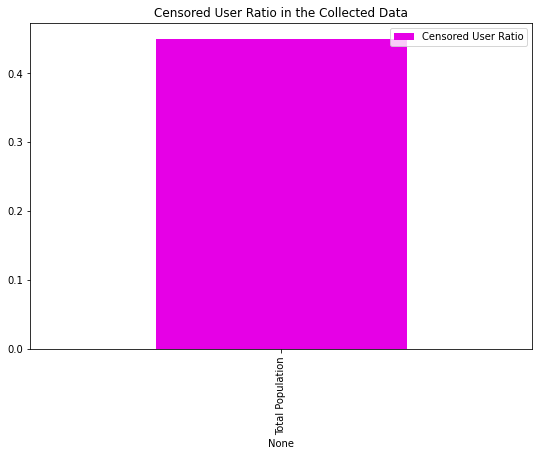

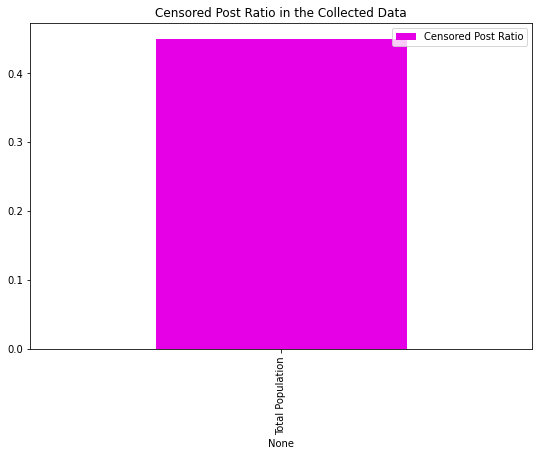

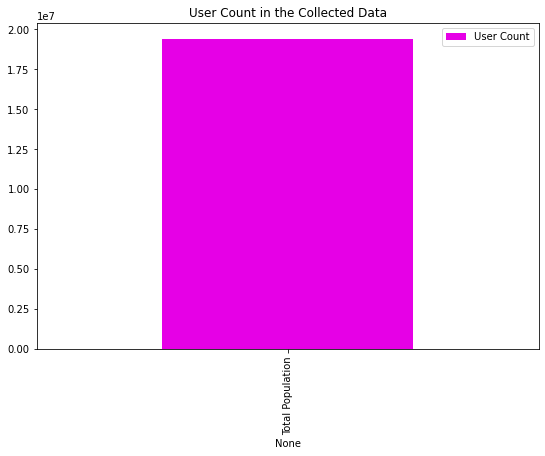

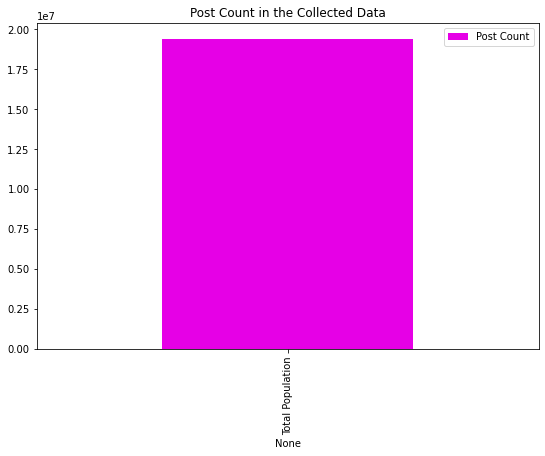

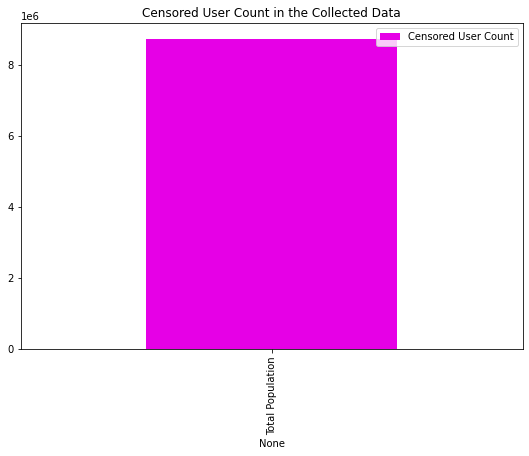

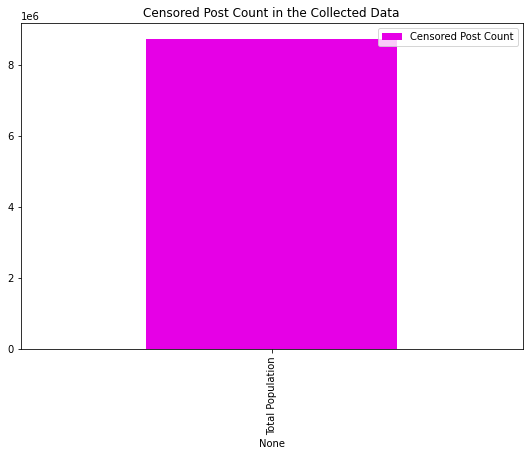

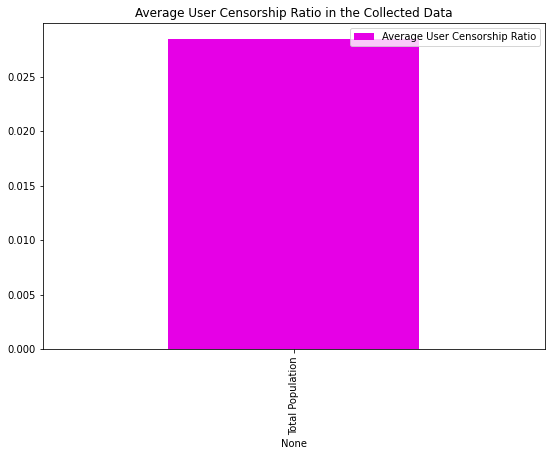

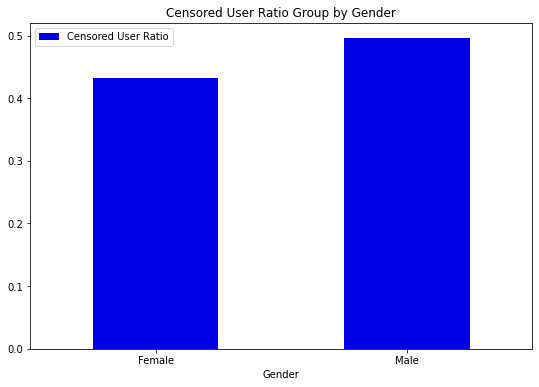

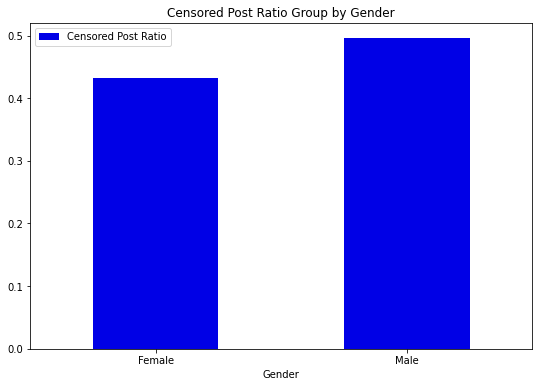

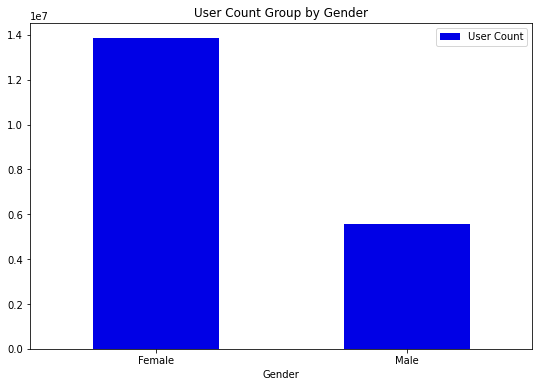

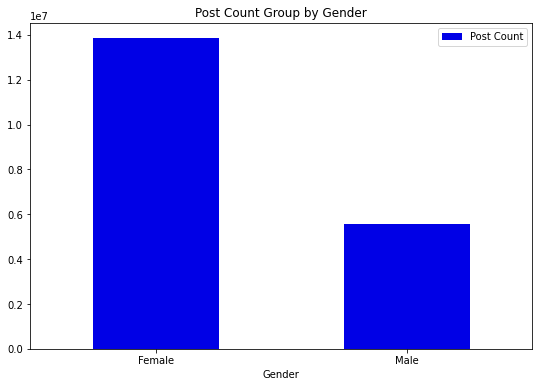

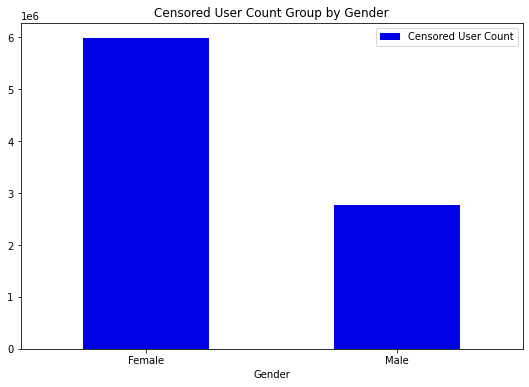

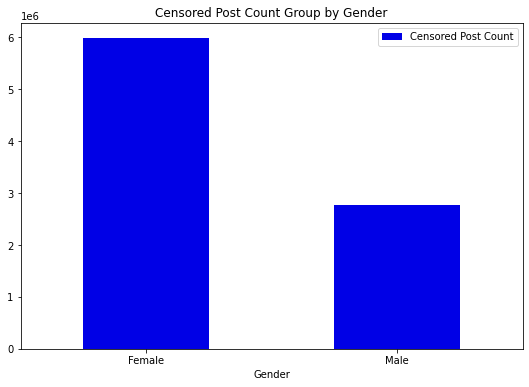

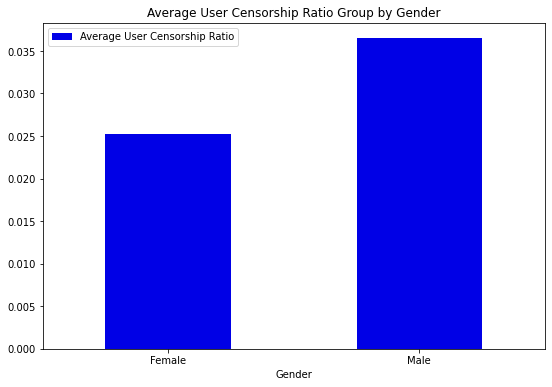

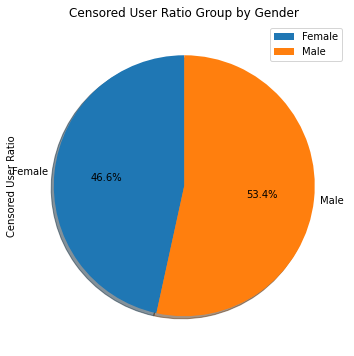

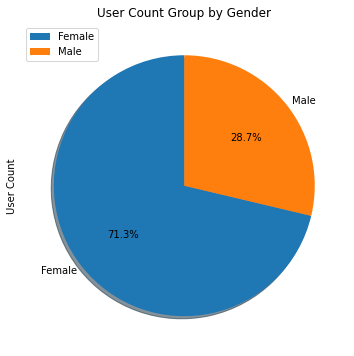

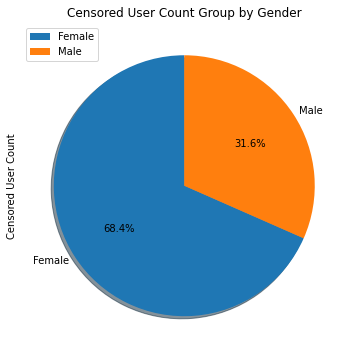

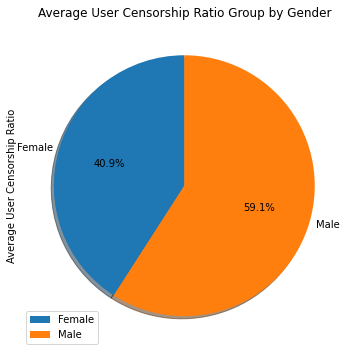

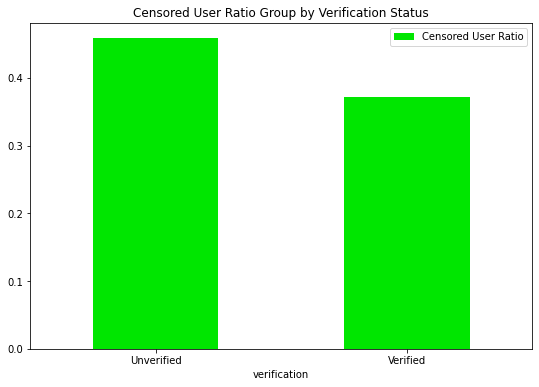

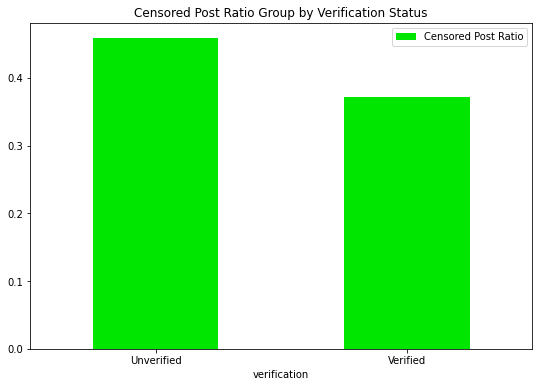

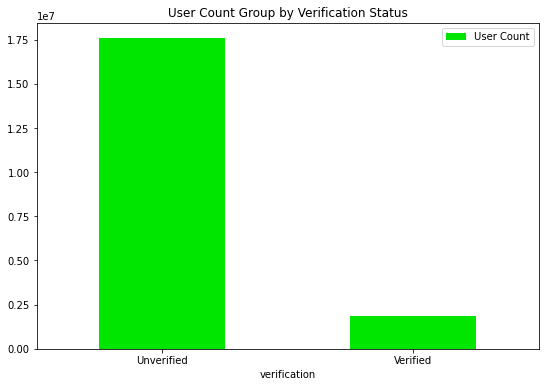

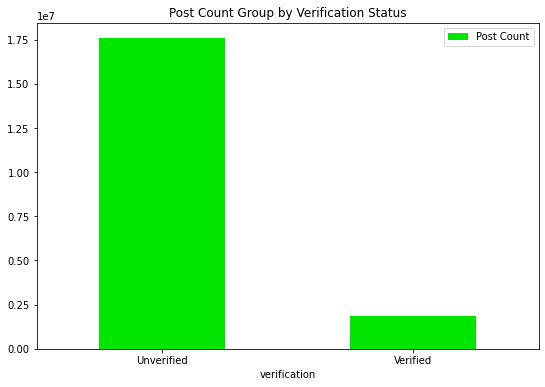

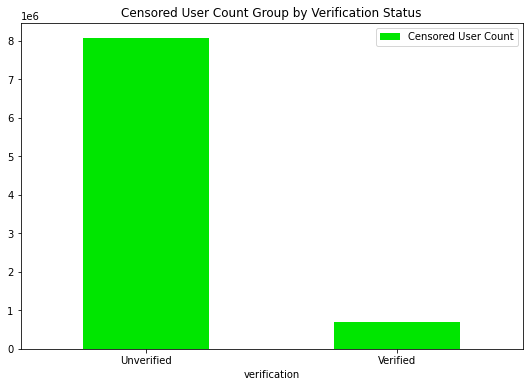

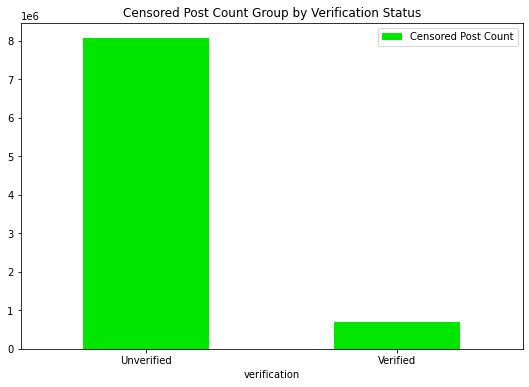

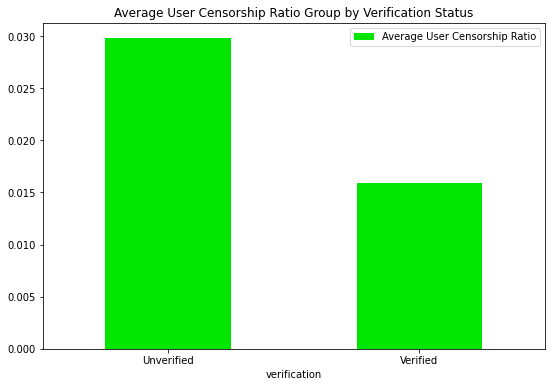

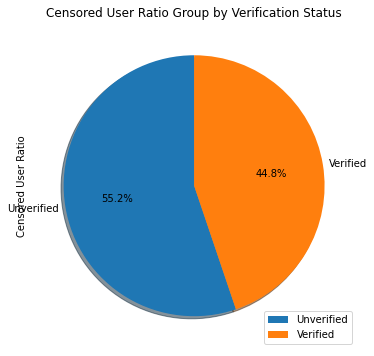

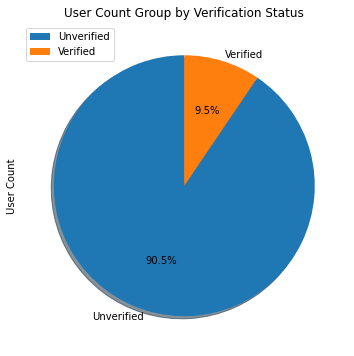

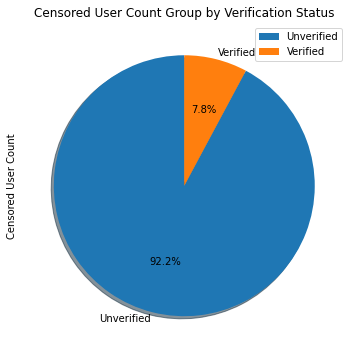

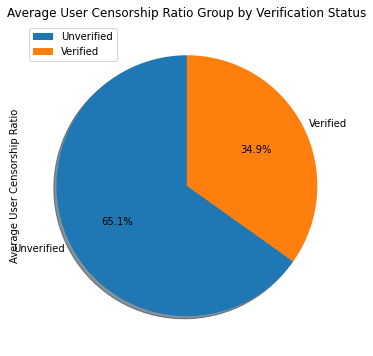

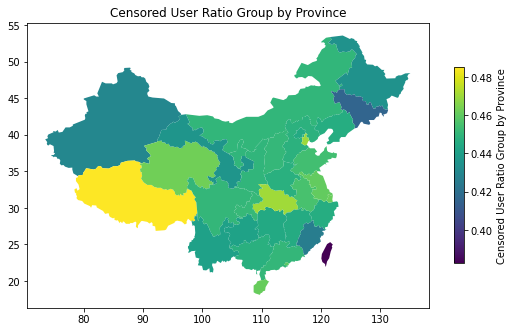

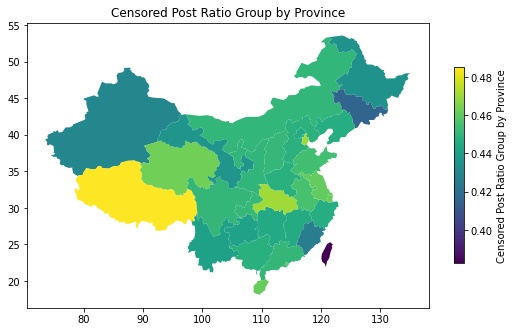

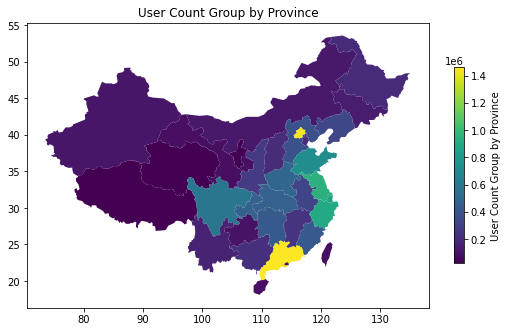

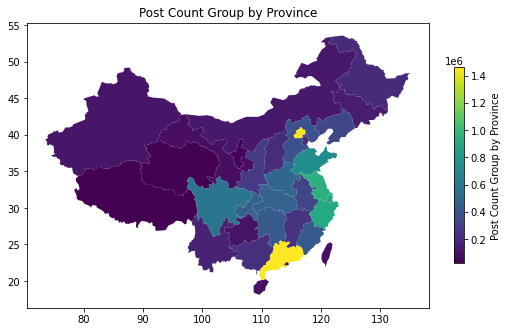

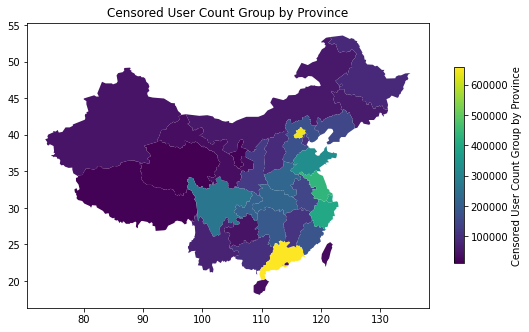

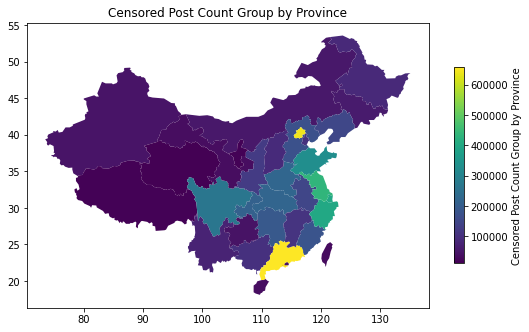

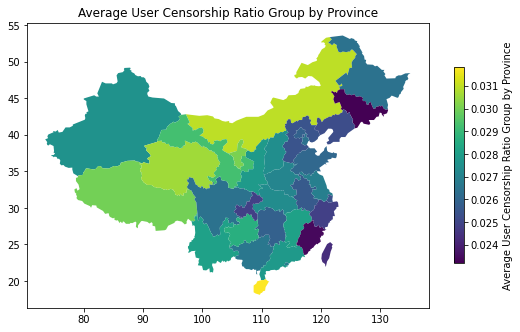

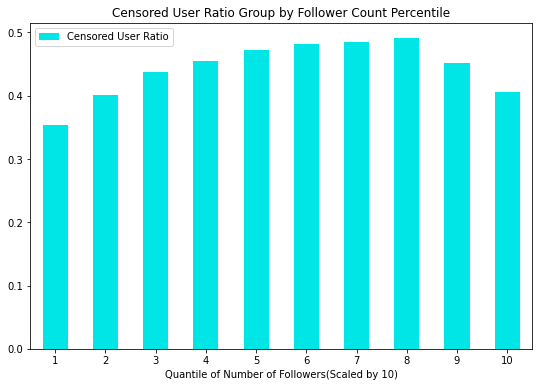

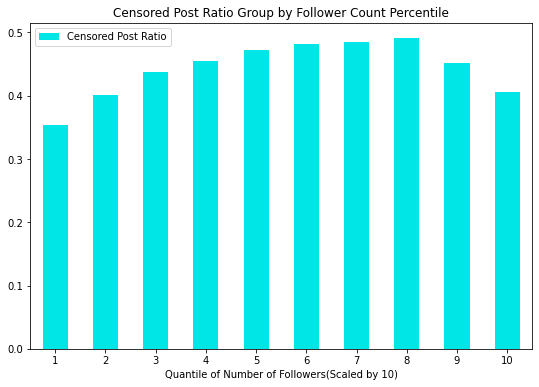

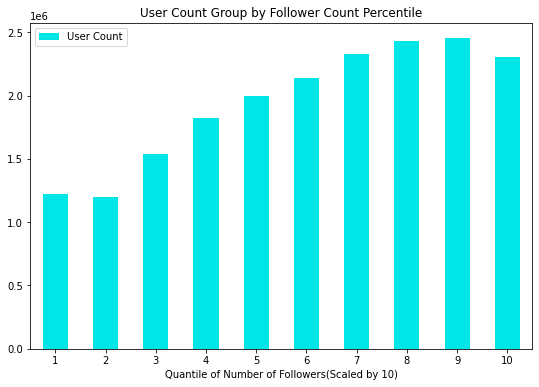

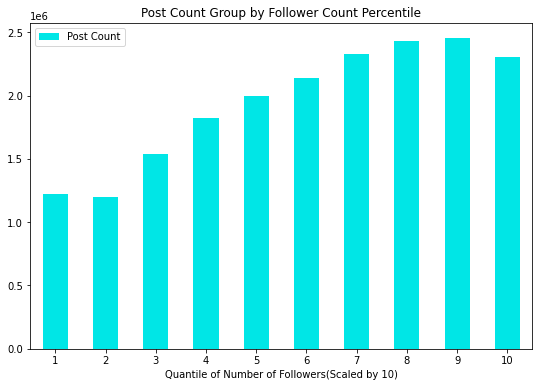

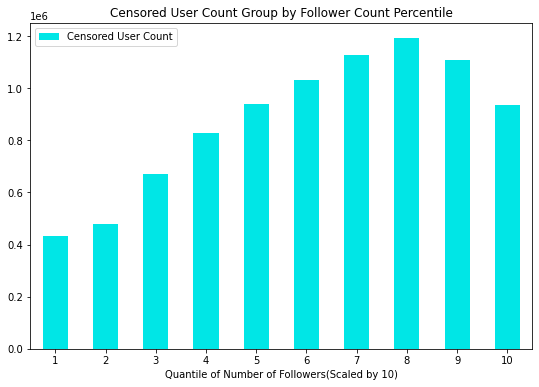

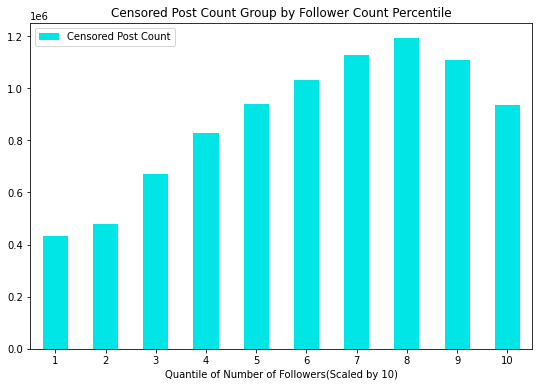

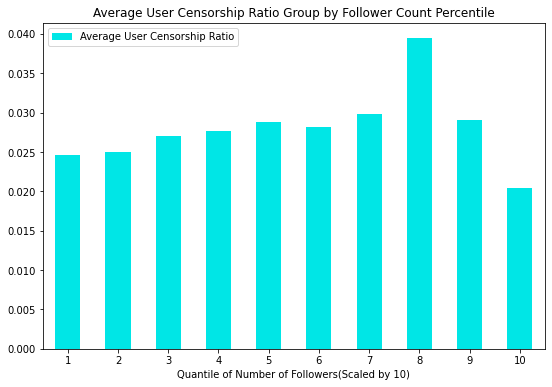

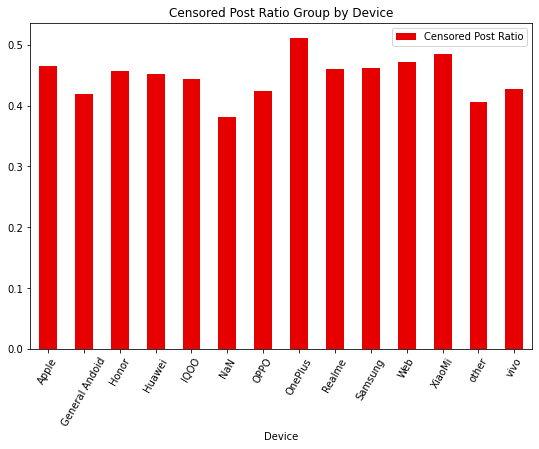

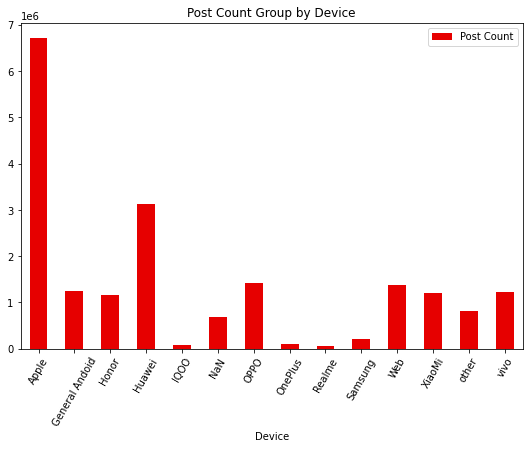

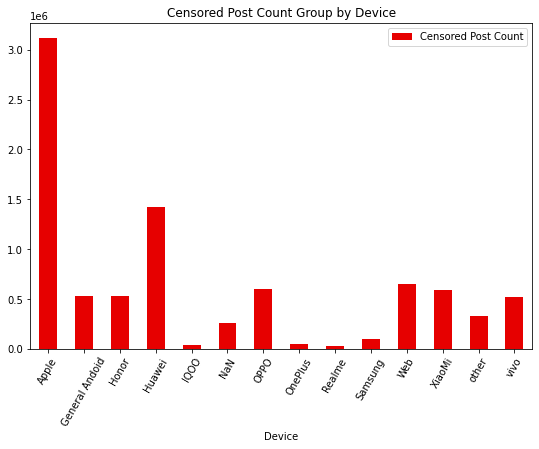

In [15]:
plt.rcParams.update({'figure.max_open_warning': 0}) # Suppress max plot num open warning
for groupby_col in columns:
    for analysis in metrics:
        for df_title, df in all_dfs.items():
            if df_title in groupby_col.applicable_dfs and df_title in analysis.applicable_dfs:
                analyze(post_df, analysis, groupby_col, df_title)

<a name="double-groupby-analysis" />

### Double Group-by Column Batch Analysis

In [74]:
column_group_nums = {col.col_name: len(post_df.groupby(col.col_name)) for col in columns if col.col_name}
column_group_nums

{'gender': 2,
 'verification': 2,
 'province': 36,
 '#follower_percentile_grouped': 10,
 'general_device': 14}

In [152]:
def nested_column_analyze(df, analysis, col1, col2, df_title):

    # Ensures that number of groups in col1 is greater than number of groups in col2.
    if column_group_nums[col1.col_name] < column_group_nums[col2.col_name]:
        col1, col2 = col2, col1
    
    study_name = analysis.chart_analysis_name.format(df_title)

    output = pd.DataFrame({
        col1.col_name: df[col1.col_name],
        col2.col_name: df[col2.col_name],
        study_name: analysis.columns_selector(df)
    }).groupby([col1.col_name, col2.col_name]).agg(analysis.analyze_func)
    
    output.reset_index(inplace=True)
    if col1.post_process_mapping is not None or col2.post_process_mapping is not None:
        if col1.post_process_mapping is not None:
            output[col1.col_name] = output[col1.col_name].map(col1.post_process_mapping)
        if col2.post_process_mapping is not None:
            output[col2.col_name] = output[col2.col_name].map(col2.post_process_mapping)

    output = output.pivot(col1.col_name, col2.col_name)
    output.columns = [f"{study_name} for {col2name}" for study_name, col2name in output.columns]
    
    plot(output, 
         'bar', 
         title = f"{study_name} Group by {col1.chart_name} and {col2.chart_name}",
         color = None
        )

# nested_column_analyze(users_with_content, metrics[0], columns[4], columns[2], "User")

/home/sean/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


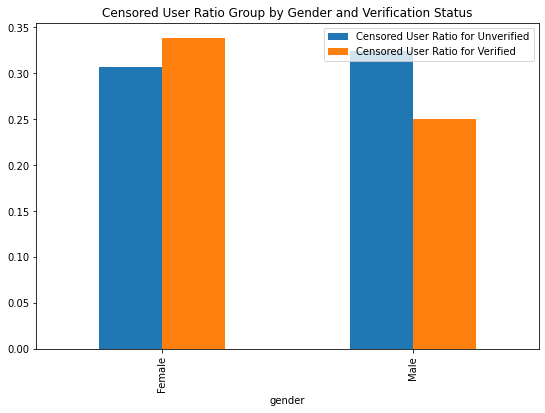

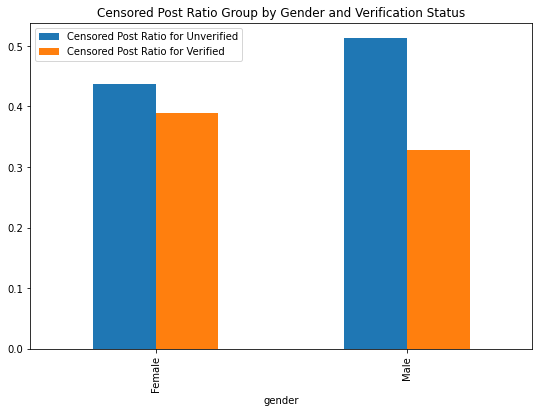

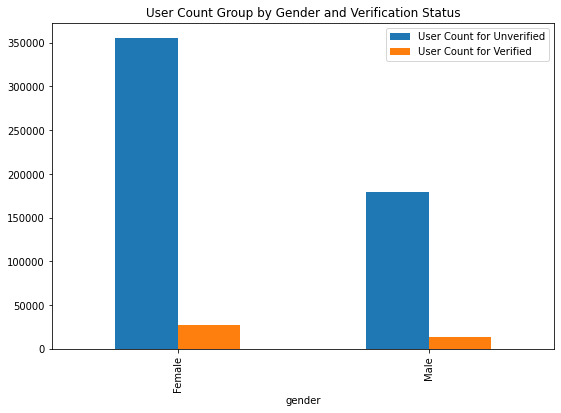

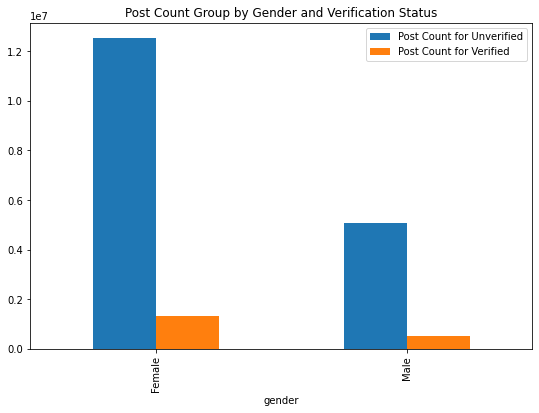

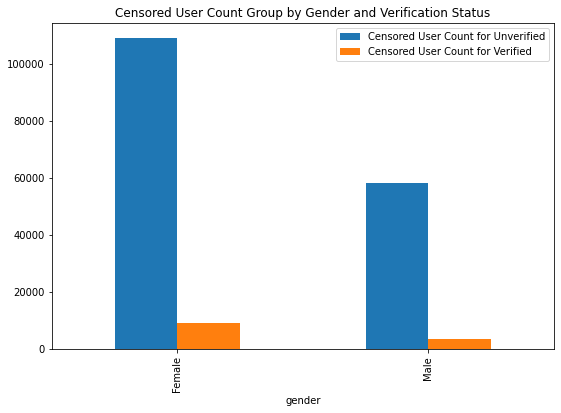

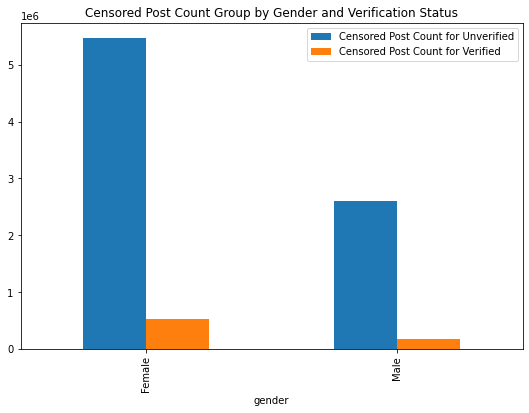

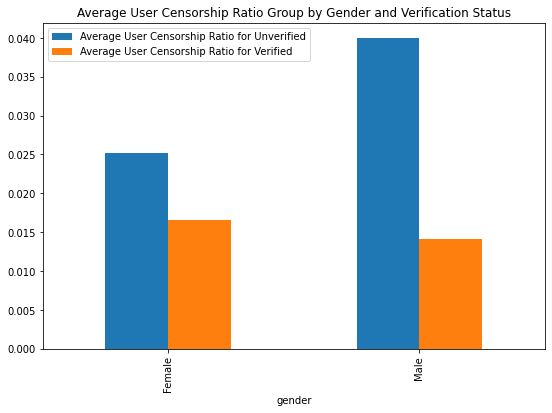

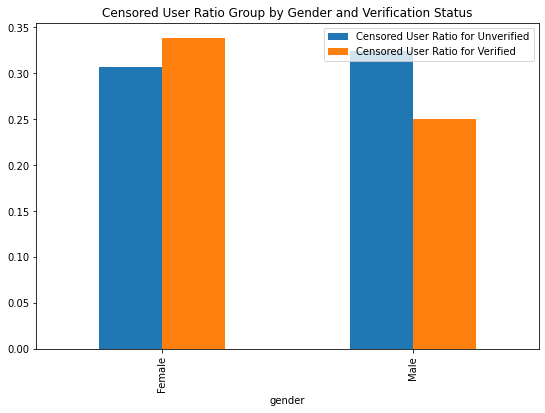

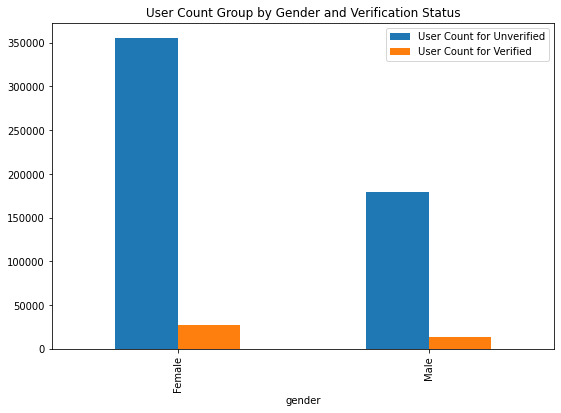

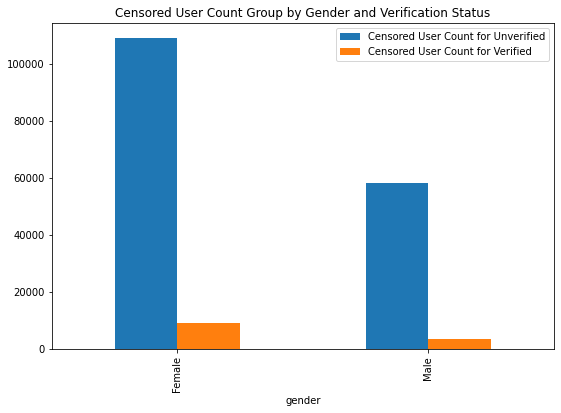

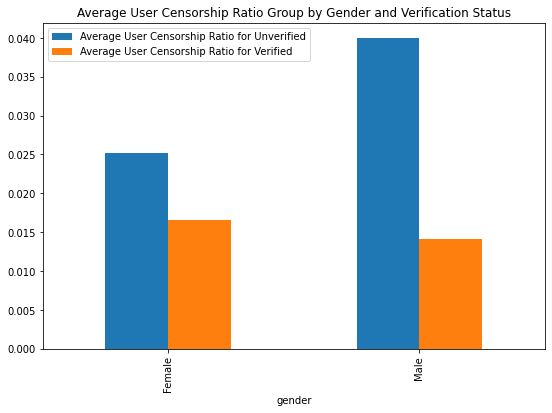

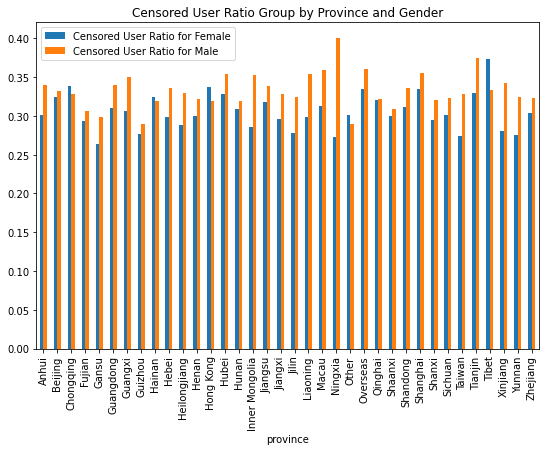

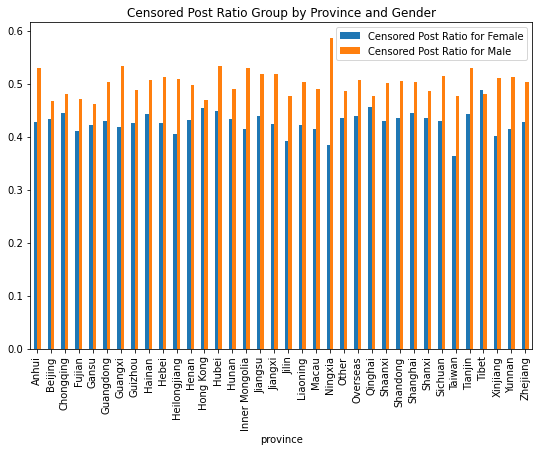

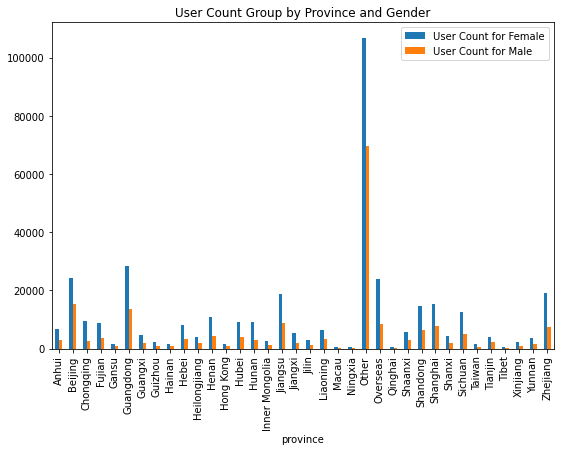

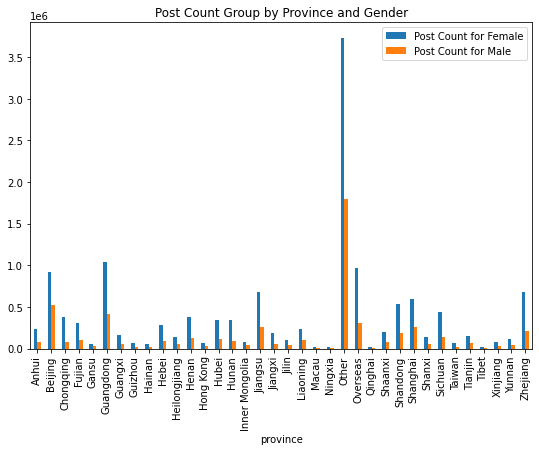

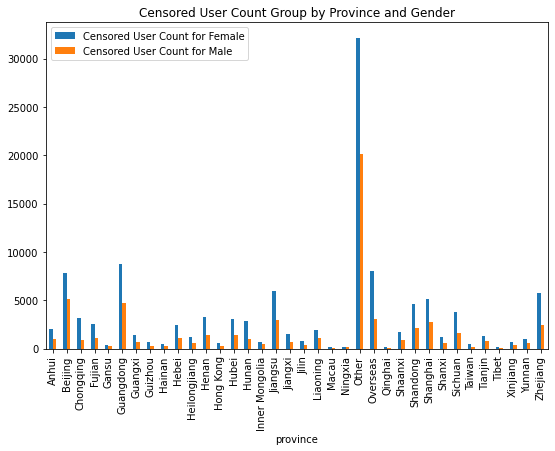

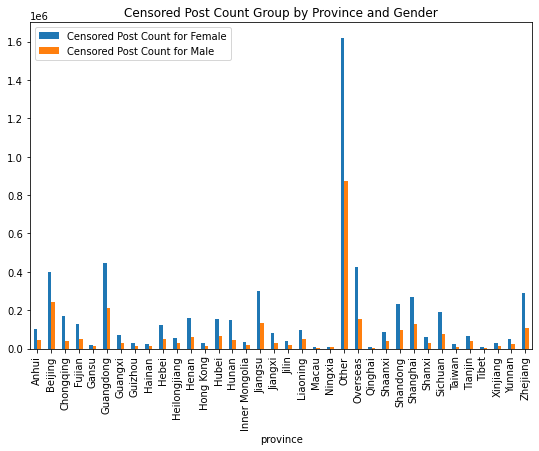

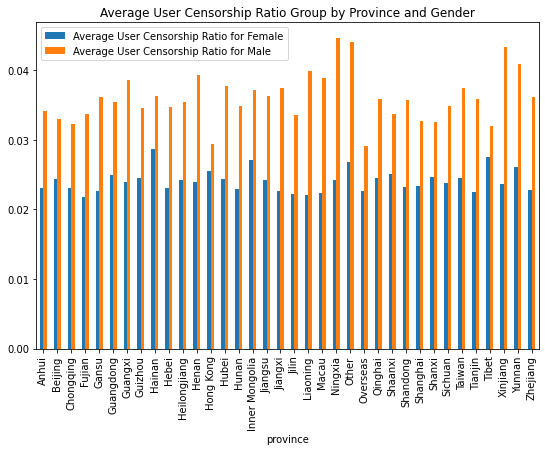

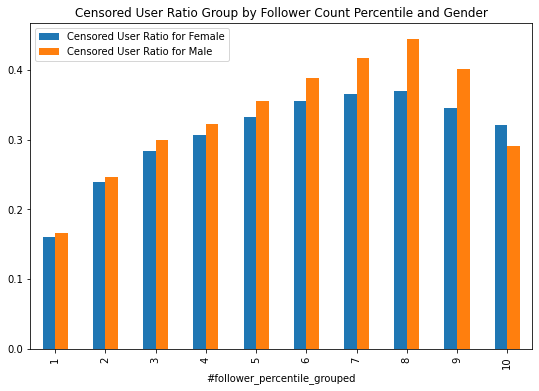

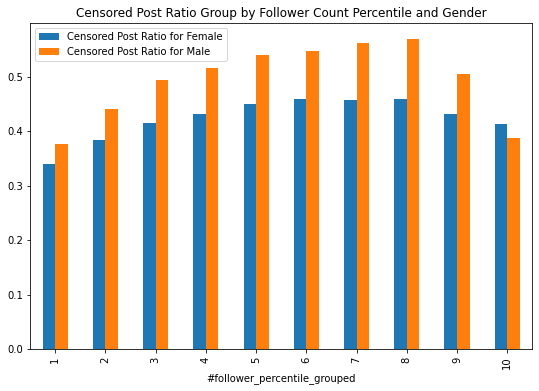

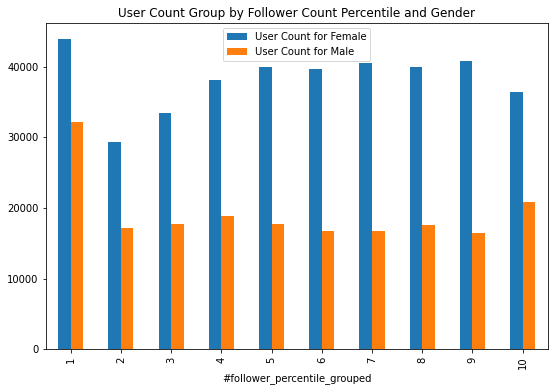

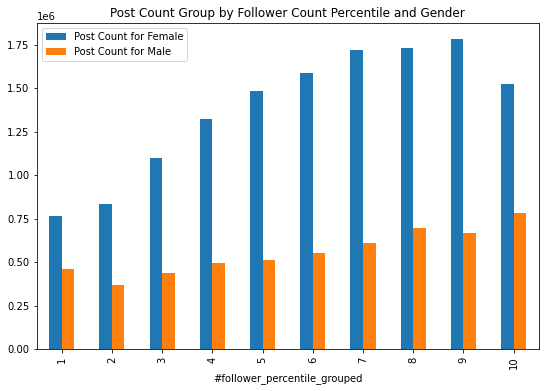

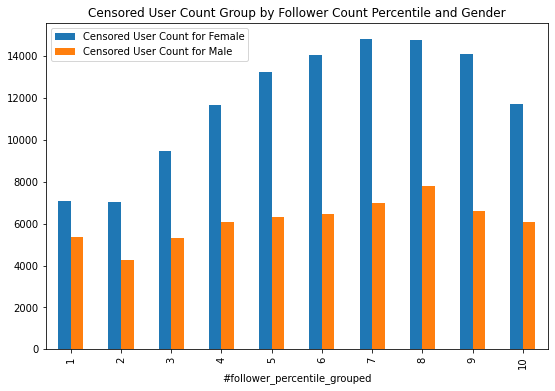

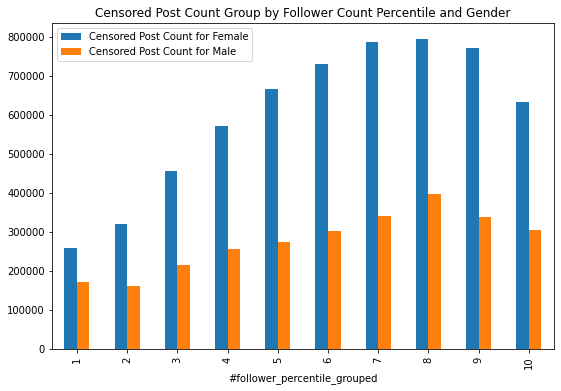

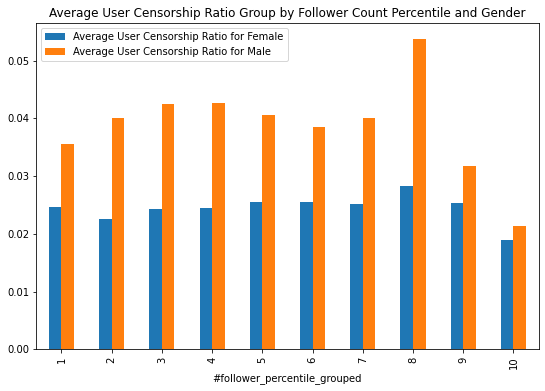

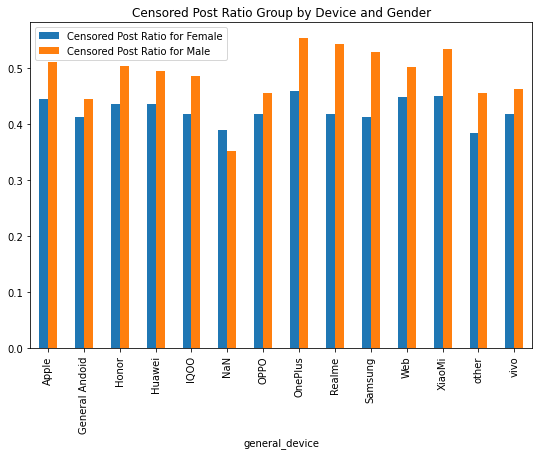

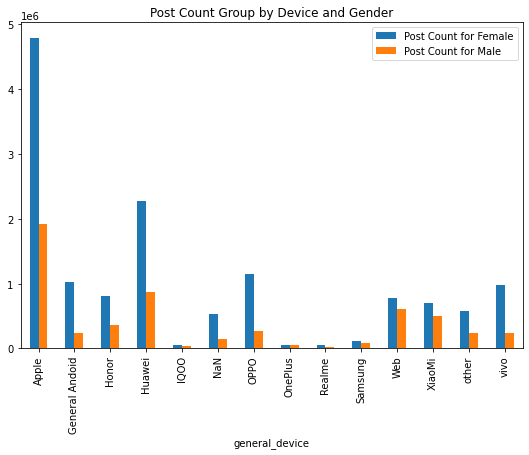

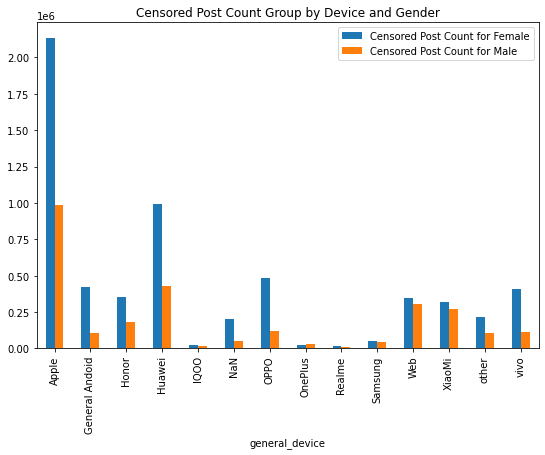

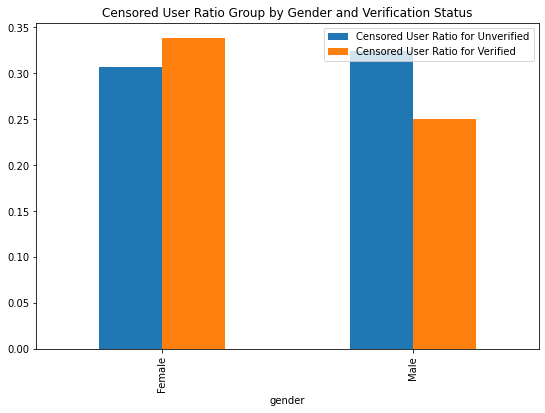

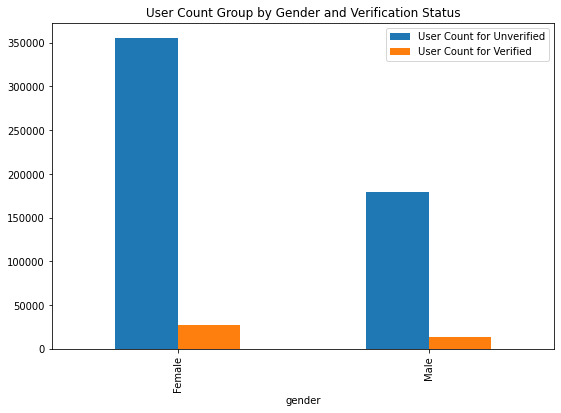

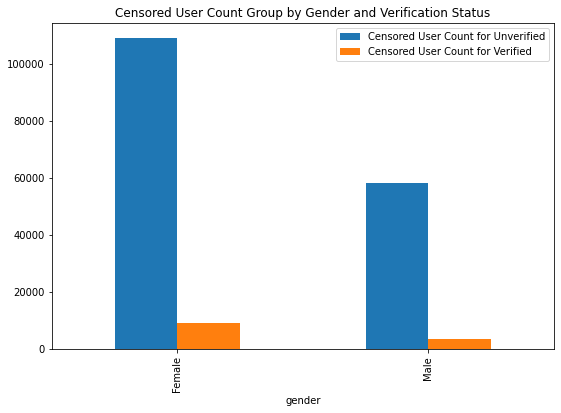

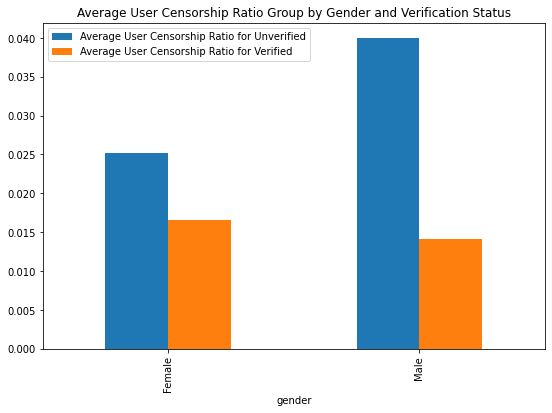

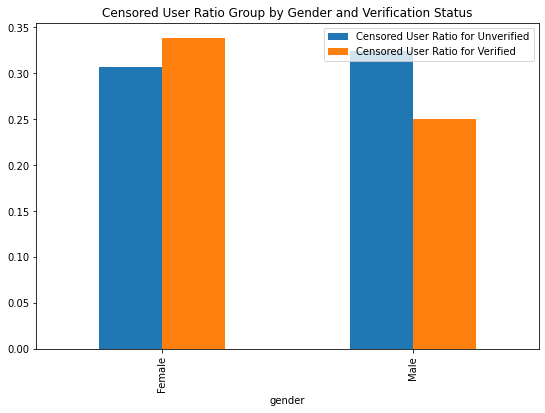

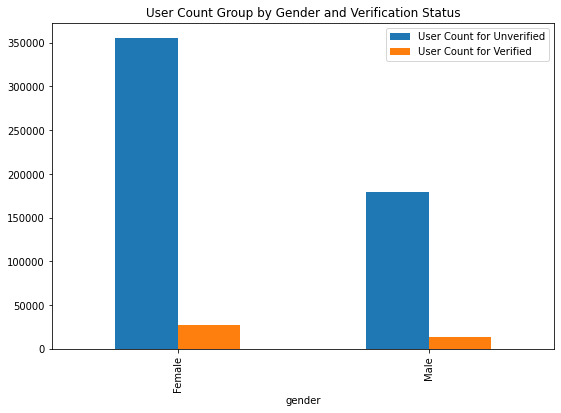

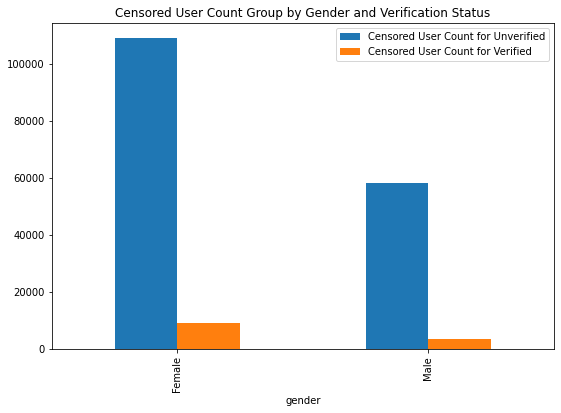

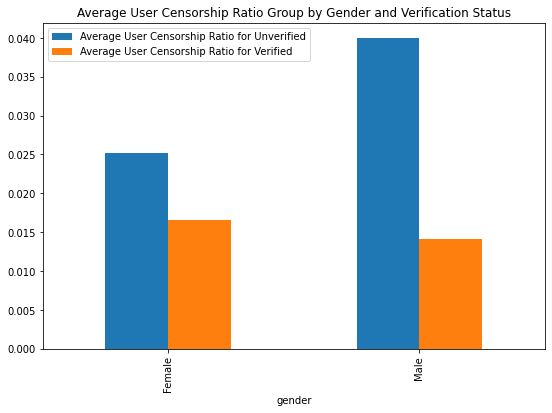

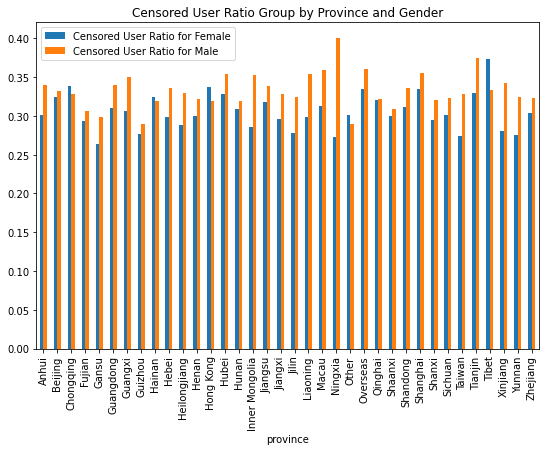

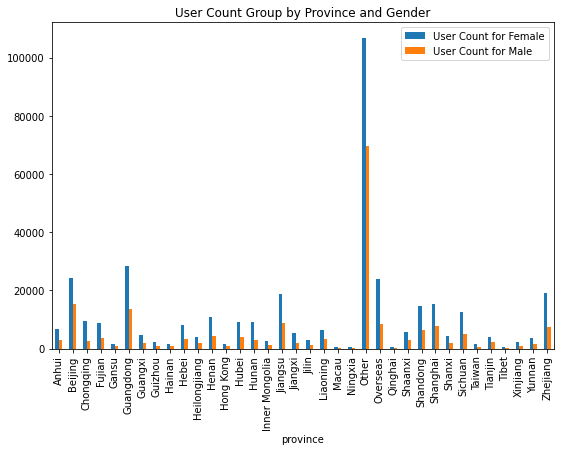

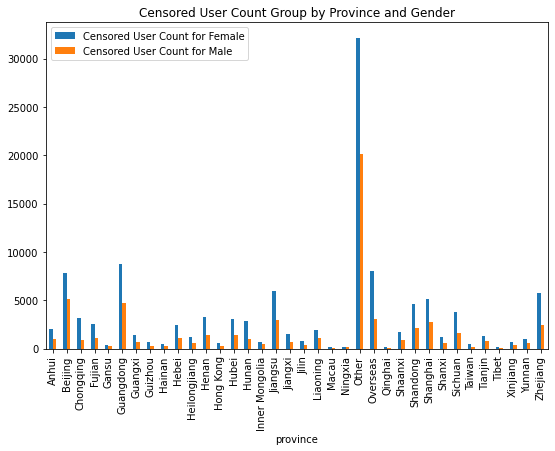

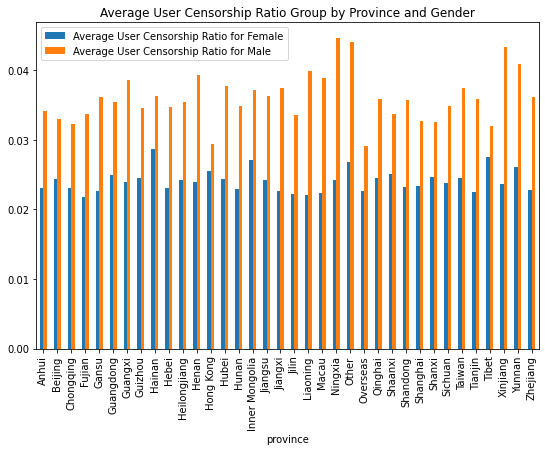

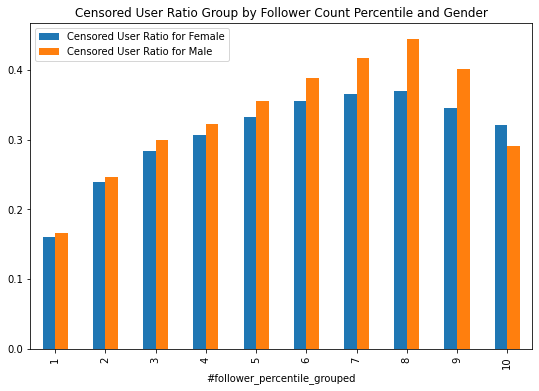

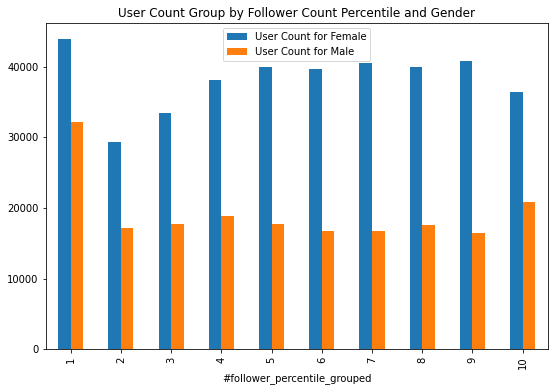

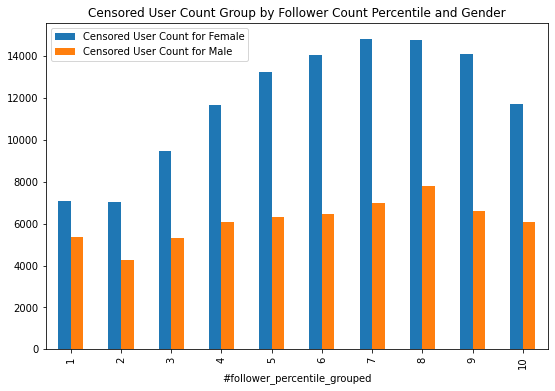

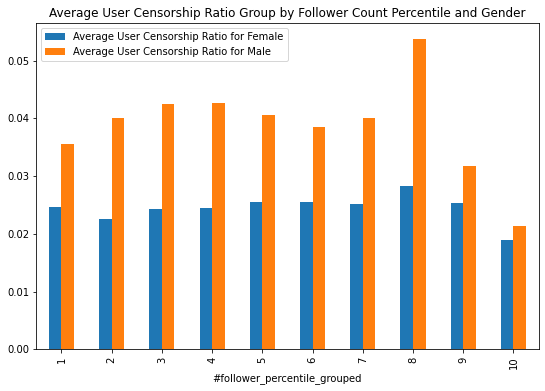

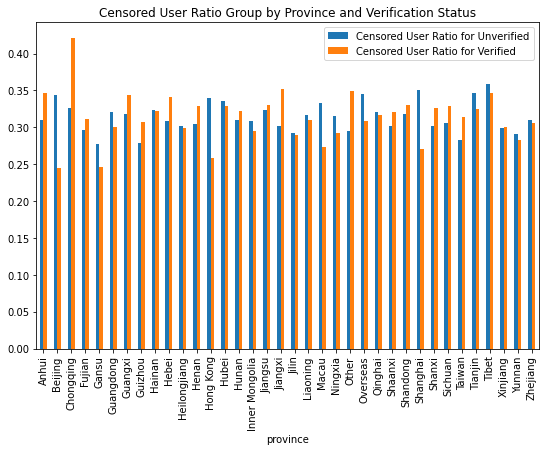

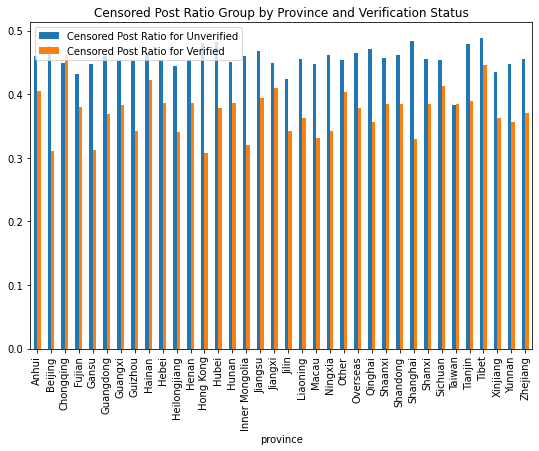

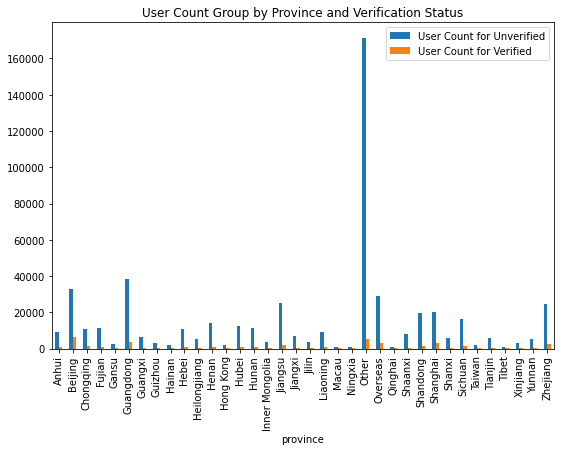

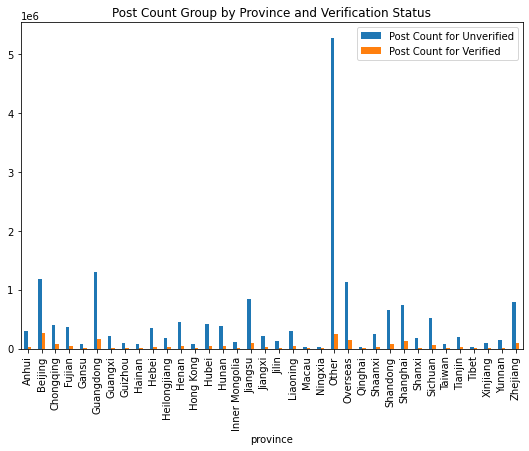

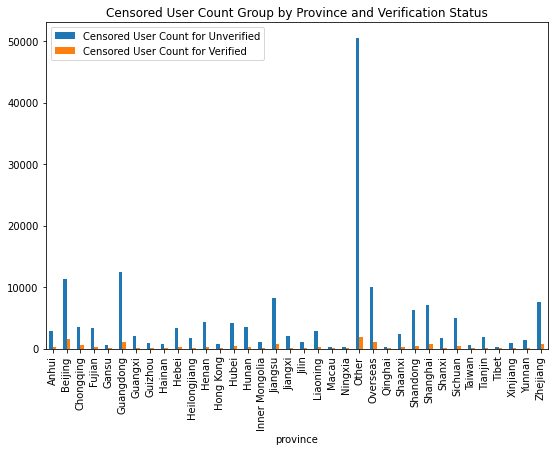

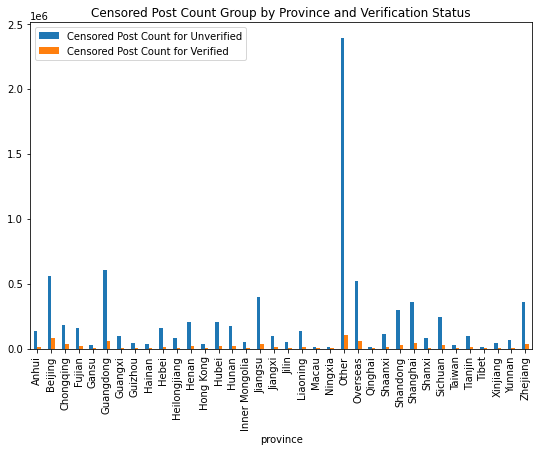

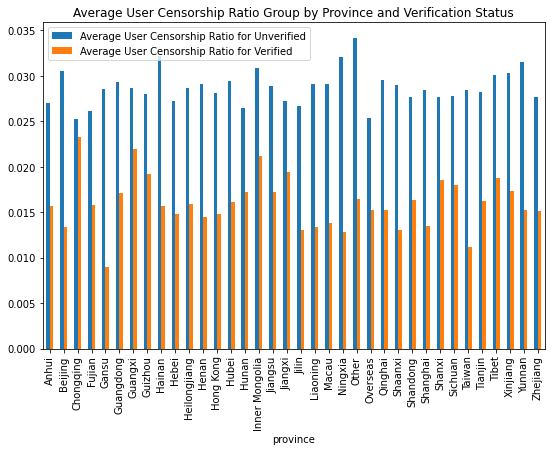

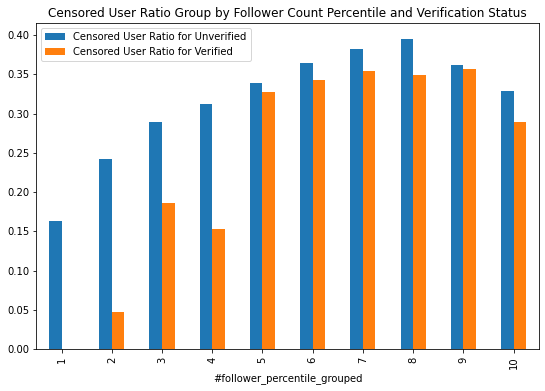

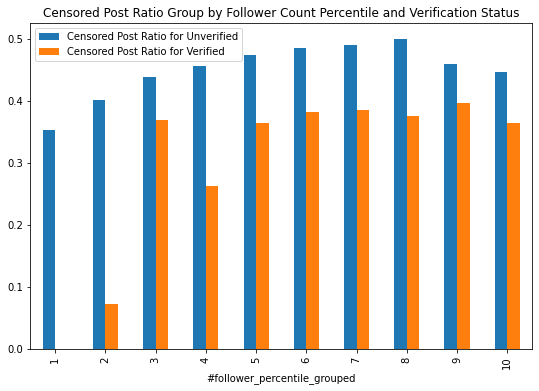

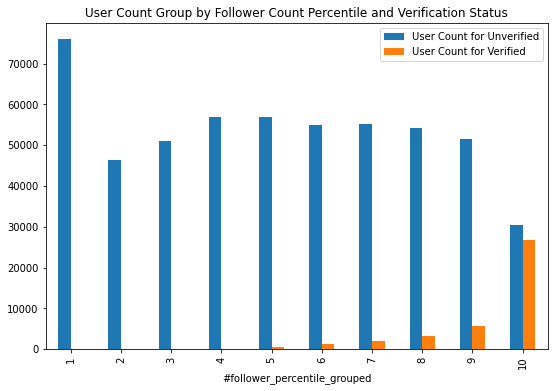

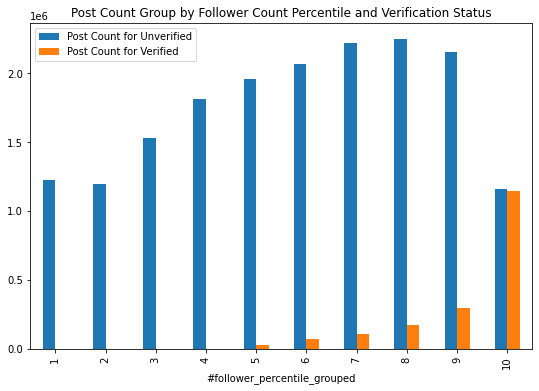

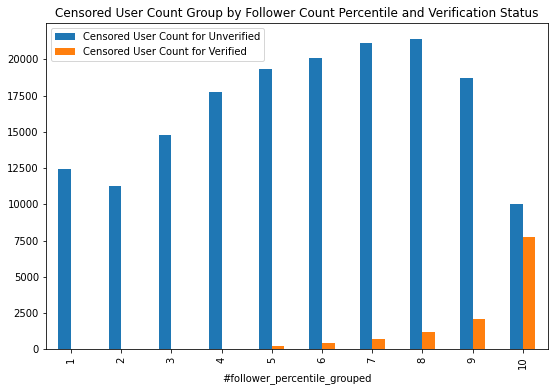

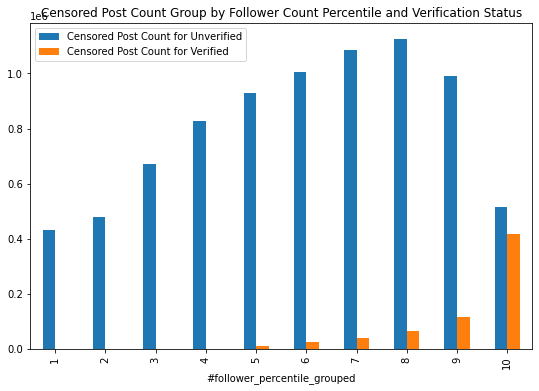

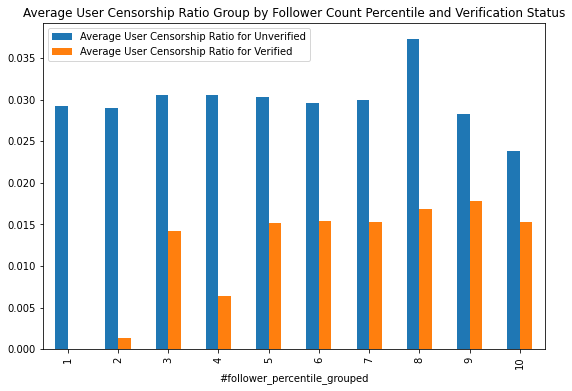

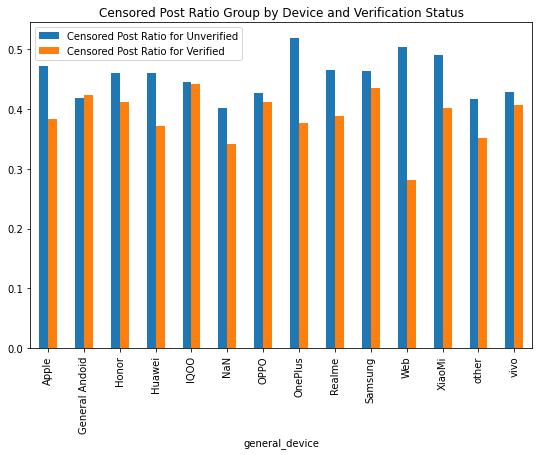

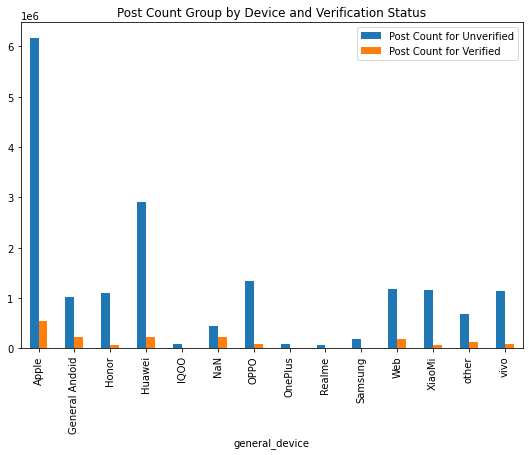

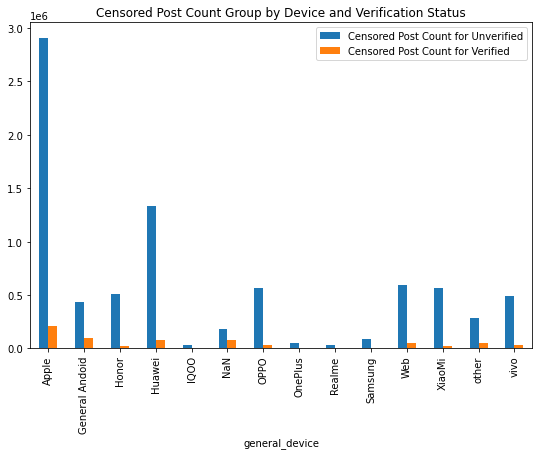

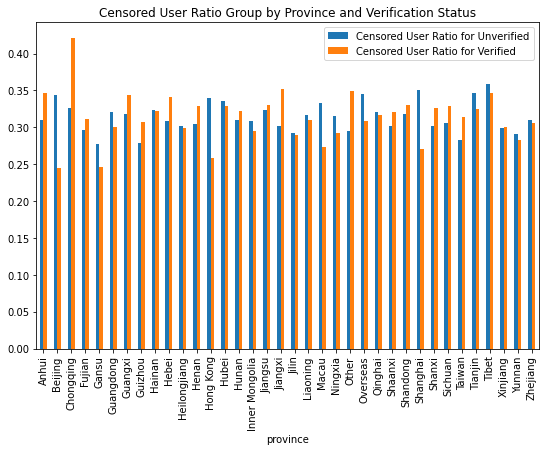

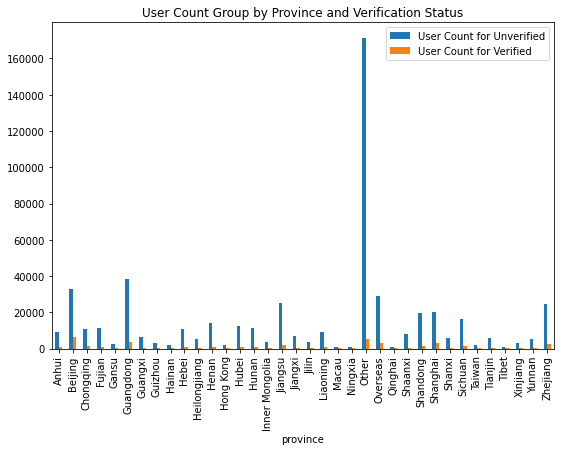

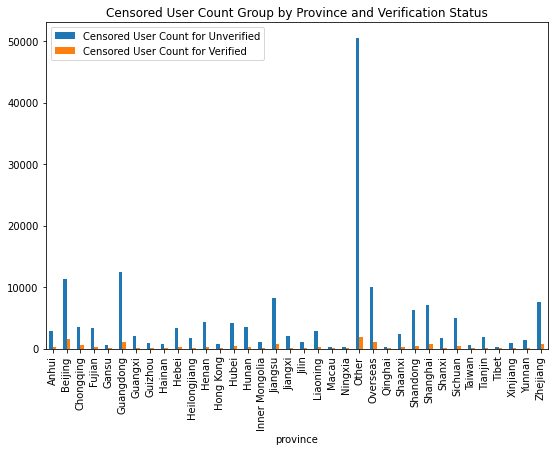

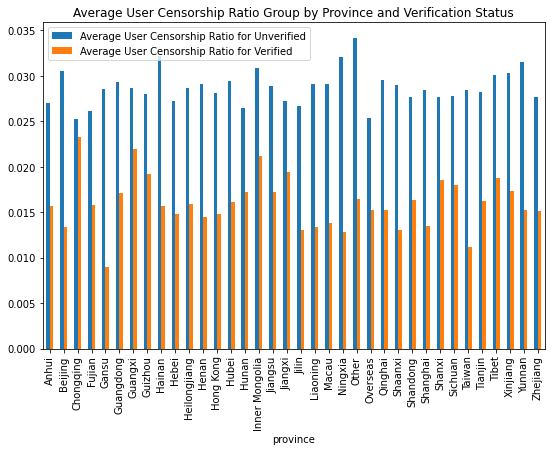

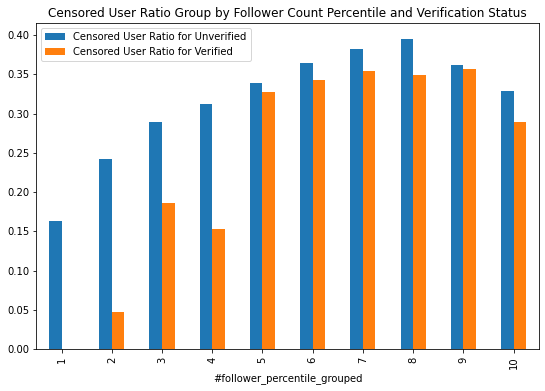

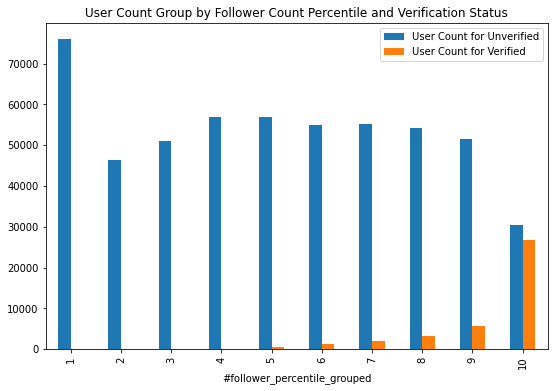

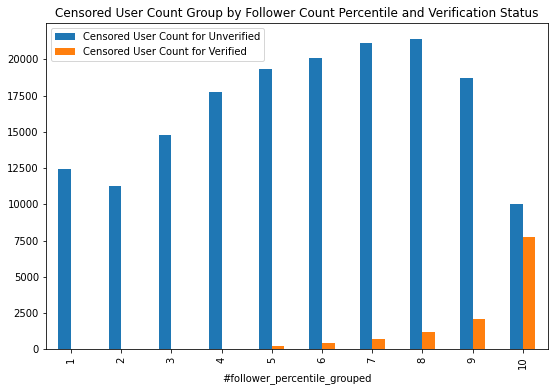

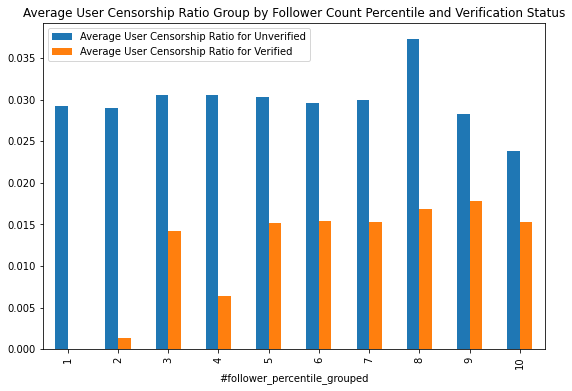

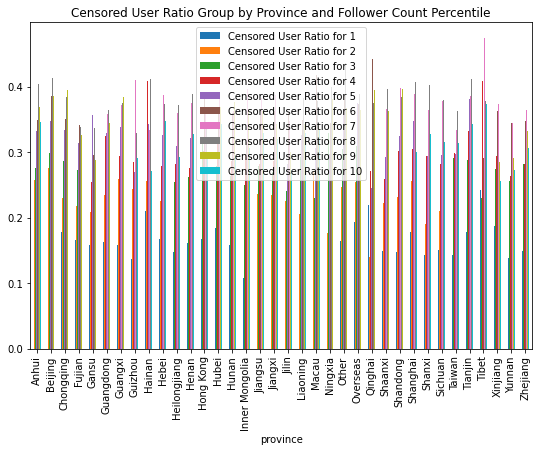

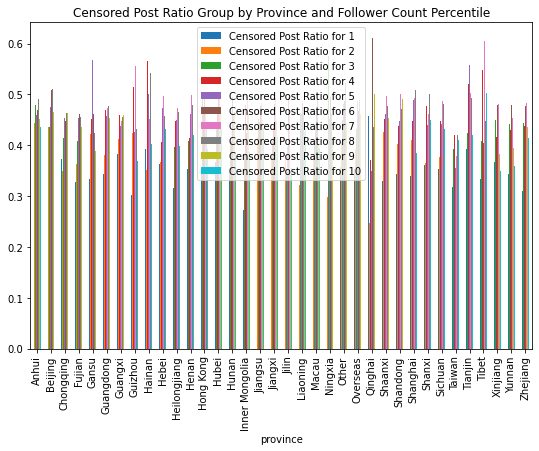

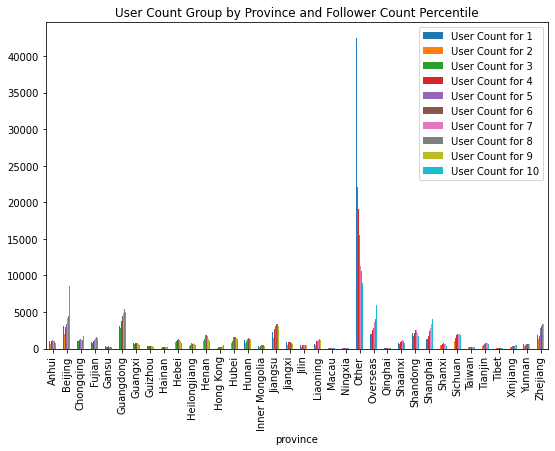

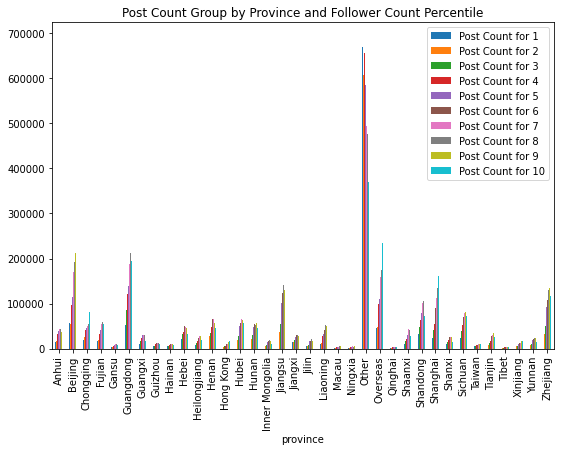

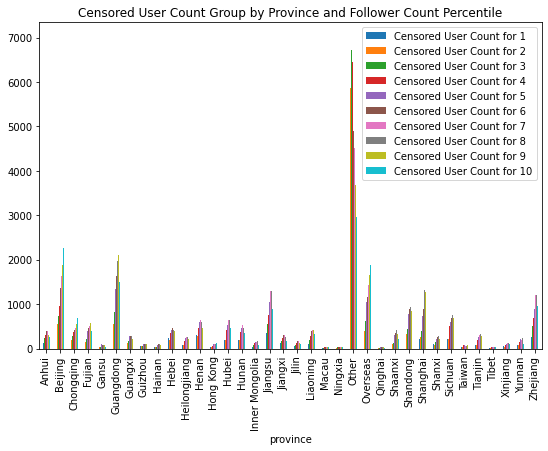

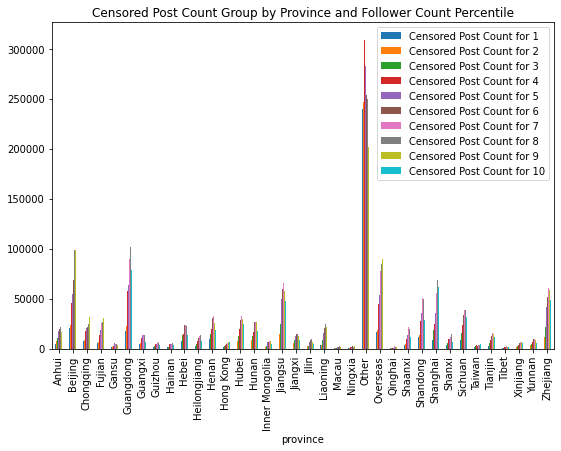

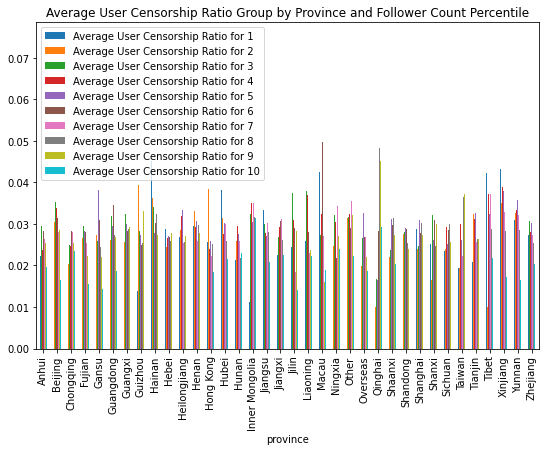

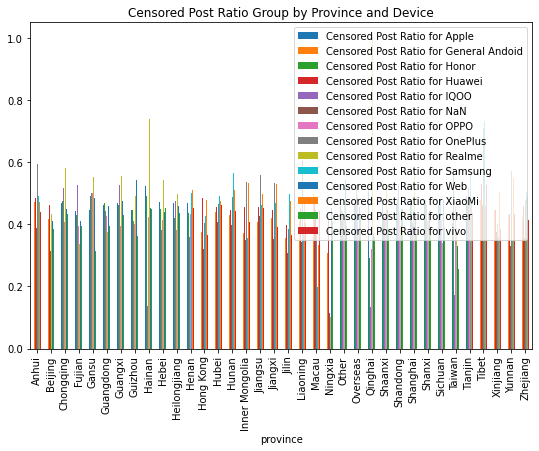

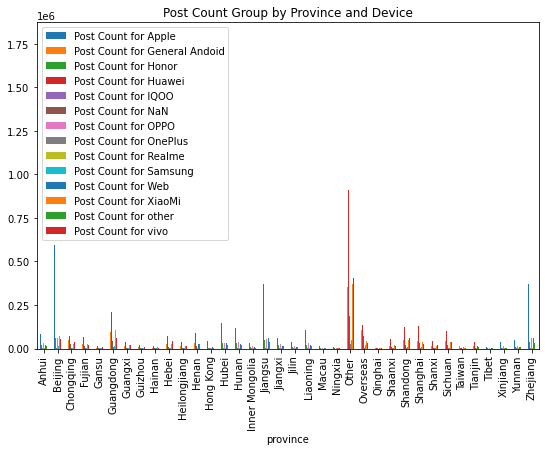

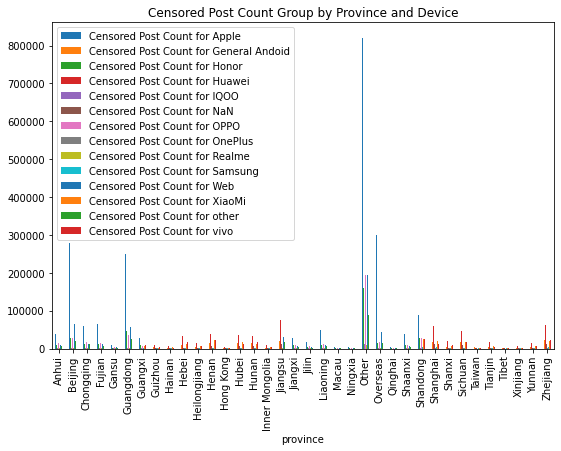

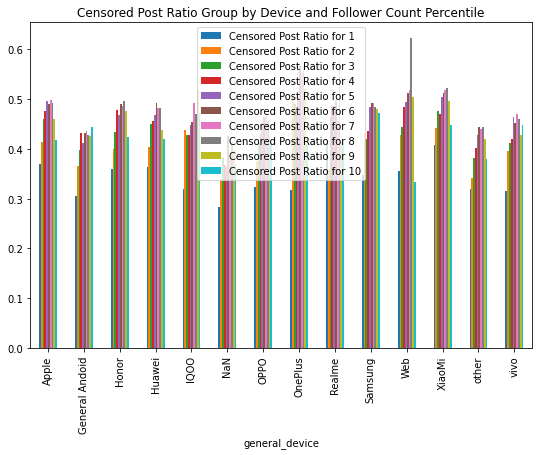

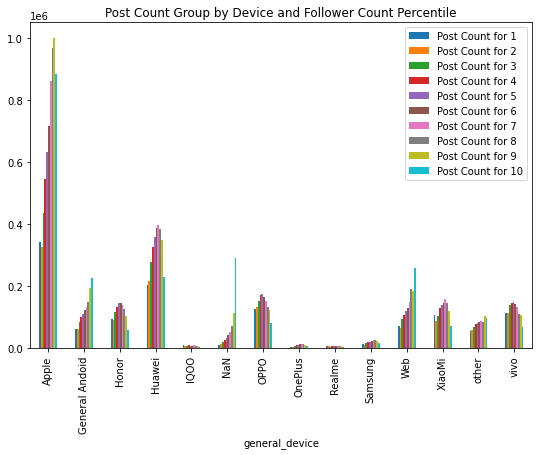

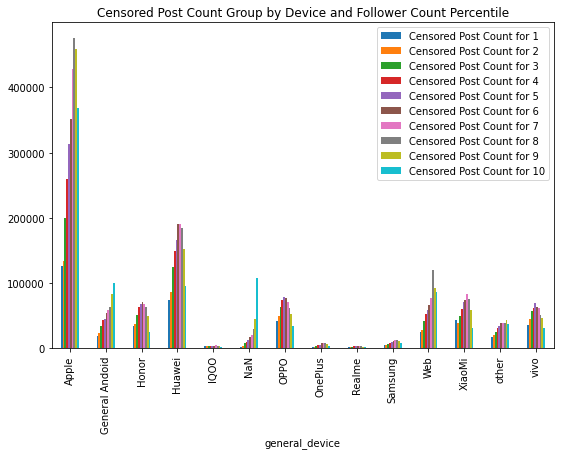

In [151]:
plt.rcParams.update({'figure.max_open_warning': 0}) # Suppress max plot num open warning

for i, groupby_col1 in enumerate(columns):
    if groupby_col1.col_name is None:
        continue
    for j, groupby_col2 in enumerate(columns[i+1:],i+1):
        if groupby_col1.col_name == groupby_col2.col_name:
            continue
        for analysis in metrics:
            for df_title, df in all_dfs.items():
                if all(
                    (df_title in dfs_list for dfs_list in [
                        groupby_col1.applicable_dfs, groupby_col2.applicable_dfs, analysis.applicable_dfs
                ])):
                    nested_column_analyze(df, analysis, groupby_col1, groupby_col2, df_title)

<a name="word-cloud"/>

# Word Cloud

## Topic Extraction -makeup

In [170]:
with open('topic_models.pkl','rb') as f:
    models = pickle.load(f)

In [2]:
from google.cloud import translate_v2 as translate
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="translator-47347b8d079f.json"
translate_client = translate.Client()
print(type(translate_client))


<class 'google.cloud.translate_v2.client.Client'>


In [184]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from random import choice
lda_best = models[6]
topics_best = []
lda_best.print_topics(num_topics=9, num_words=20)
for topic in lda_best.print_topics(num_topics=9,num_words=20):
    topics_best.append(topic[1])
    
# take topics to dictionary
def convert_to_dict(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[i[1].strip().replace('"','')] = float(i[0]) * 1e3
    return frequency_dict

# take topics to a translated dictionary
def convert_to_dict_trans(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[translate_client.translate(i[1].strip().replace('"',''), target_language='en')['translatedText']] = float(i[0]) * 1e3
    return frequency_dict

# draw a word cloud for each sub-topic
def cloud_each_topic(topics:list,model_name:str,trans:bool):
    for i in range(len(topics)):
        topic_words = topics[i]
        if trans:
            freq_dict = convert_to_dict_trans(topic_words)
        else:
            freq_dict = convert_to_dict(topic_words)
        draw_cloud(freq_dict,1,'%s_%d' %(model_name,i))
        
def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq,tp:0, name_file:str): #tp = 0 means general, tp = 1 means the plot for each subtopic
    if tp == 0:
        width = 800
        height = 400
    else:
        width = 400
        height = 200
    wc = WordCloud(font_path='HuaWenHeiTi-1.ttf',  # 设置字体
                   background_color="white",  # 背景颜色
                   max_words=300,  # 词云显示的最大词数
                   max_font_size=80,  # 字体最大值
                   random_state=42,
                   width = width,
                   height = height)
    
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10,5))
    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file('./figures/%s.png' %name_file)

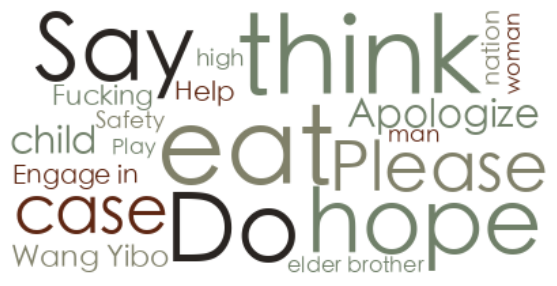

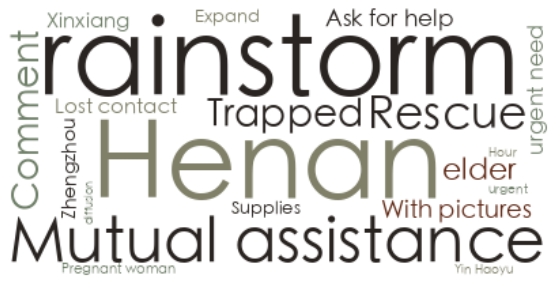

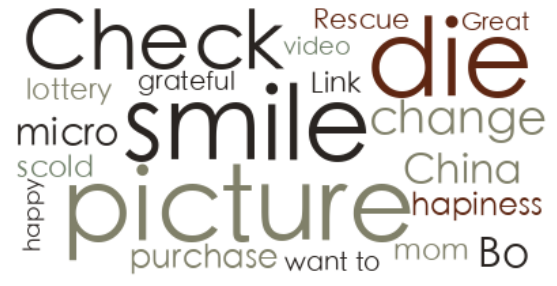

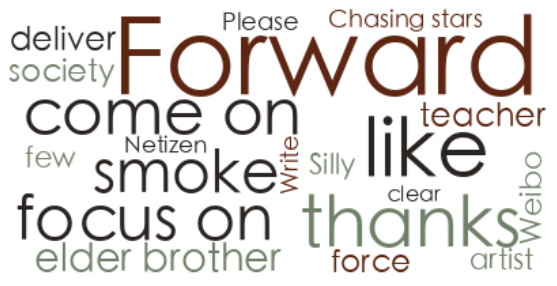

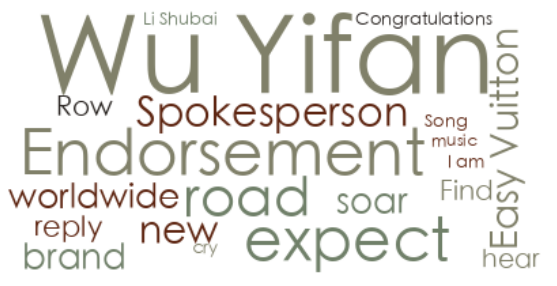

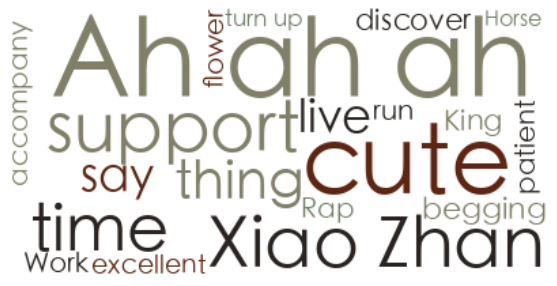

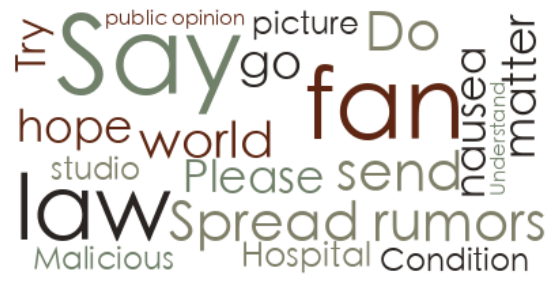

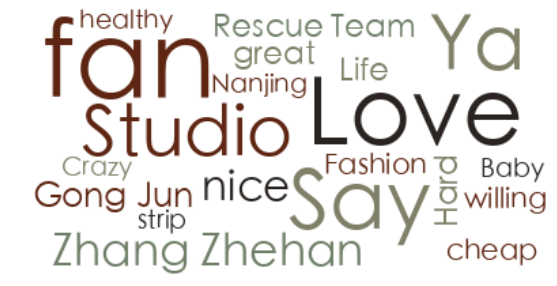

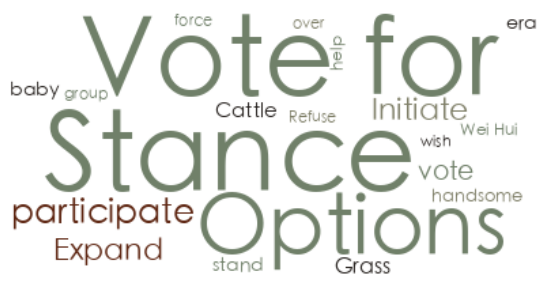

In [185]:
cloud_each_topic(topics_best,'best_model_trans',True)

## A module to take a peek at the topics in a certain area

In [202]:
import jieba
import jieba.posseg
from wordcloud import WordCloud, STOPWORDS
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities
import gensim
import re

my_file = open('complete_stop_words.txt',encoding="utf8")
stop_words = my_file.read().splitlines()

def cut_words_with_pos(text):
    seg = jieba.posseg.cut(text)
    res = []
    for word, flag in seg:
        if flag in ["a", "v", "x", "n", "an", "vn", "nz", "nt", "nr", "ns", "nw", "eng"] and (word not in stop_words):
            res.append(word)
    return list(res)

def corpus_generation(df):
    corpus = np.array(df['repost_weibo_comment'])
    corpus = corpus[~pd.isnull(corpus)]
    corpus = [str(i) for i in corpus]
    # segregate comments from multiple reposters
    corpus_segregated = []
    for i in corpus:
        split_repost = re.findall(r'(?<=//@).+?(?=/|$)',i)
        if split_repost:
            corpus_segregated += [i[i.find(':')+1:] for i in split_repost]
        else:
            corpus_segregated.append(i)
    # further clean the corpus_segragated
    corpus_segregated = [i for i in corpus_segregated if i] #get rid of empty strings
    corpus_segregated = [i for i in corpus_segregated if i != '转发微博' and i != 'repost' and i != '轉發微博' and i != 'Repost'] #take out default wordings
    # take the non-chinese, non-english and non-numeric characters out of the corpus while keeping some normal punctuation marks
    pattern = re.compile(r'[^\u4e00-\u9fa5^a-z^A-Z^0-9\u3002\uff1b\uff0c\uff1a\u201c\u201d\uff08\uff09\u3001\uff1f\u300a\u300b]')
    corpus_segregated = list(map(lambda x: re.sub(pattern,'',x), corpus_segregated))
    corpus_segregated = [i for i in corpus_segregated if i]
    corpus_flat_refiend = []
    for sentence in corpus_segregated:
        corpus_flat_refiend += cut_words_with_pos(sentence)
    # take the frequency of each word
    frequency_dict = {key:0 for key in set(corpus_flat_refiend)}
    for i in corpus_flat_refiend:
        frequency_dict[i] += 1
    ranked_frequency_dict = {k: v for k, v in sorted(frequency_dict.items(), key=lambda item: item[1], reverse=True)}
    translated_frequency_dict = {}
    for key,value in list(ranked_frequency_dict.items())[:1000]:
        translated_key = translate_client.translate(key, target_language='en')['translatedText']
        translated_frequency_dict[translated_key] = value
    translated_frequency_dict['Louis Vuitton']= translated_frequency_dict.pop('Easy Vuitton')
    # to decompose each sentence into key words refined by jieba
    sentences = []
    for i in corpus_segregated:
        sentences.append(cut_words_with_pos(i))
    # bag of words model
    dictionary = corpora.Dictionary(sentences)
    corpus_topic = [dictionary.doc2bow(sentence) for sentence in sentences]

    return sentences, dictionary, corpus_topic, frequency_dict, translated_frequency_dict

def compute_coherence_values(dictionary, corpus, sentences, figure:bool):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(3,15),position=0):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,texts=sentences, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    if figure:
        plt.plot(range(3,15), coherence_values, label='coherence score(c_v)')
        plt.title('Coherence Score')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score(C_V)')
        plt.legend(loc='upper right')
        plt.savefig('./figures/coherence_score_c_v.png')
    return model_list, coherence_values

# take topics to dictionary
def convert_to_dict(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[i[1].strip().replace('"','')] = float(i[0]) * 1e3
    return frequency_dict

# take topics to a translated dictionary
def convert_to_dict_trans(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[translate_client.translate(i[1].strip().replace('"',''), target_language='en')['translatedText']] = float(i[0]) * 1e3
    return frequency_dict

# draw a word cloud for each sub-topic
def cloud_each_topic(topics:list,model_name:str,trans:bool):
    for i in range(len(topics)):
        topic_words = topics[i]
        if trans:
            freq_dict = convert_to_dict_trans(topic_words)
        else:
            freq_dict = convert_to_dict(topic_words)
        draw_cloud(freq_dict,1,'%s_%d' %(model_name,i))

def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq,tp:0, name_file:str): #tp = 0 means general, tp = 1 means the plot for each subtopic
    if tp == 0:
        width = 800
        height = 400
    else:
        width = 400
        height = 200
    wc = WordCloud(font_path='HuaWenHeiTi-1.ttf',  # 设置字体
                   background_color="white",  # 背景颜色
                   max_words=300,  # 词云显示的最大词数
                   max_font_size=80,  # 字体最大值
                   random_state=42,
                   width = width,
                   height = height)
    
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10,5))
    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    #wc.to_file('./figures/%s.png' %name_file)        

def find_location_topic(location=None, wo_censor=bool, year=None, month=None):
    list_df_w_censor = []
    list_df_wo_censor = []
    for i in tqdm(range(12)):
        with open('./df/final_post_full_%d.df' %i, 'rb') as f:
            df_w_post = pickle.load(f)
        if location:
        df_w_post_censor = df2_w_post[(df_w_post['province']==location) & (df_w_post['censored_post']==True)]
        if year:
            # take out nan values
            df_w_post_censor = df_w_post_censor[~df_w_post_censor['timestamp_month']]
            df_w_post_censor = df
        list_df_w_censor.append(df_w_post_censor)
        if wo_censor:
            df_w_post_wo_censor = df_w_post[(df_w_post['province']==location) & (df_w_post['censored_post']==False)]
            list_df_wo_censor.append(df_w_post_wo_censor)
    df_repost_censor = pd.concat(list_df_w_censor)
    if wo_censor:
        df_repost_wo_censor = pd.concat(list_df_wo_censor) 
    sentences, dictionary, corpus, frequency_dict, translated_frequency_dict = corpus_generation(df_repost_censor)
    # plot the general wc
    draw_cloud(frequency_dict,0,'general_wc_%s' %location)
    draw_cloud(translated_frequency_dict,0,'translated_general_wc_%s' %location)
    # find the best topics
    models, coherence_values = compute_coherence_values(dictionary,corpus,sentences)
    best_model = models[coherence_values.index(max(coherence_values))]
    topics_best = []
    for topic in best_model.print_topics(num_topics=coherence_values.index(max(coherence_values))+3, num_words=20):
        topics_best.append(topic[1])
    # best model to word cloud
    cloud_each_topic(topics_best,'best_model_%s' %location,False)
    cloud_each_topic(topics_best,'best_model_trans_%s' %location,True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:47<00:00,  4.00s/it]


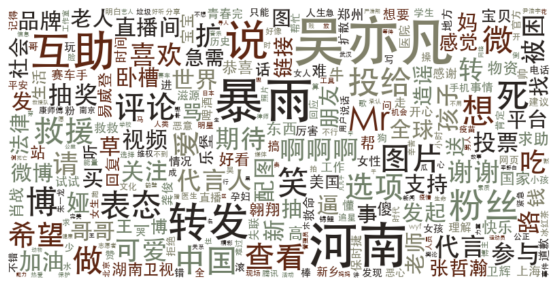

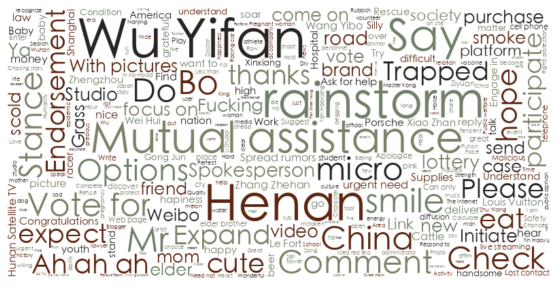

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.43s/it]


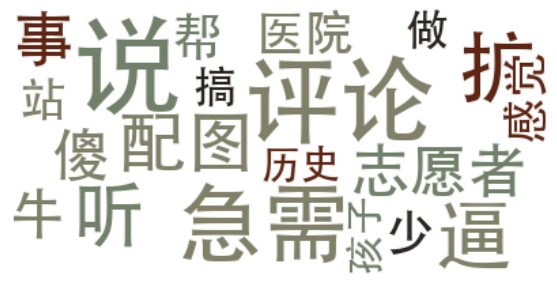

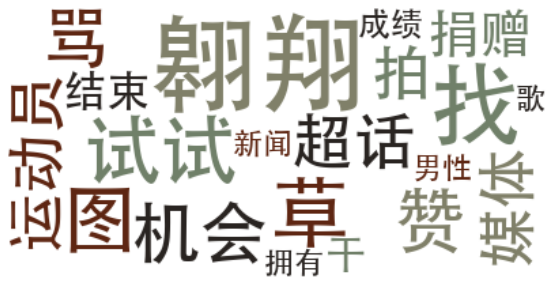

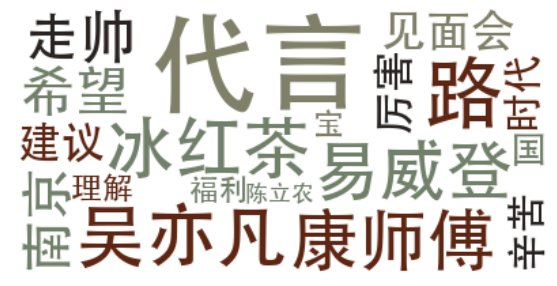

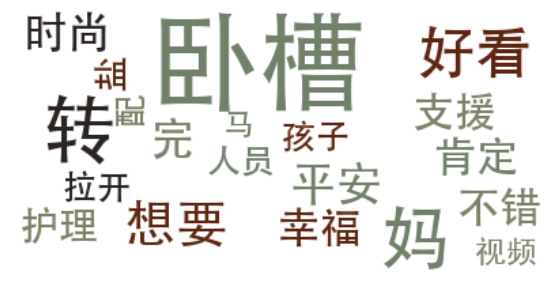

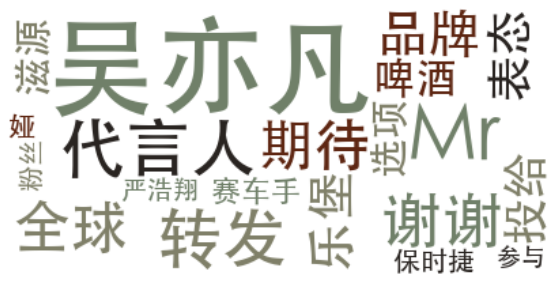

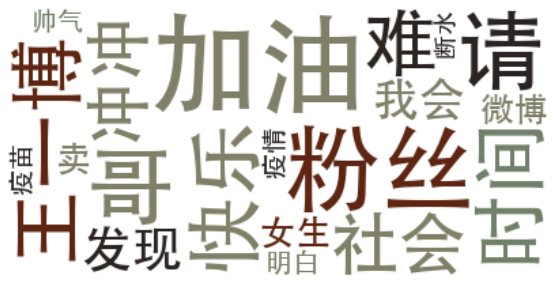

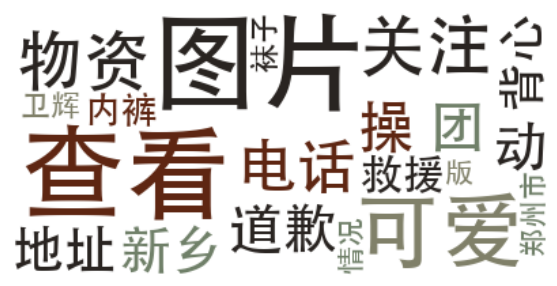

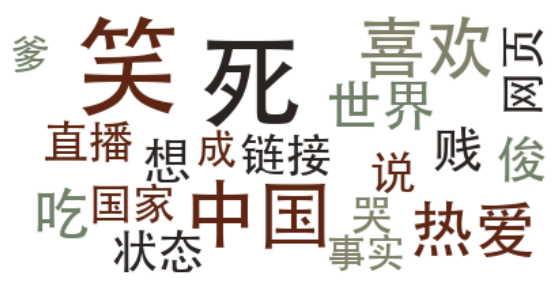

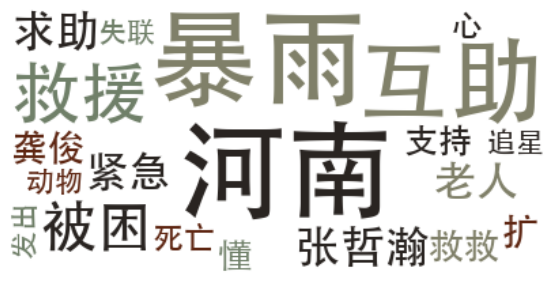

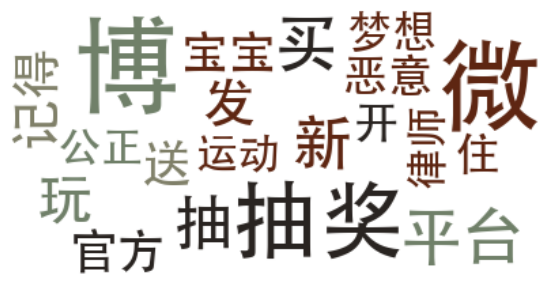

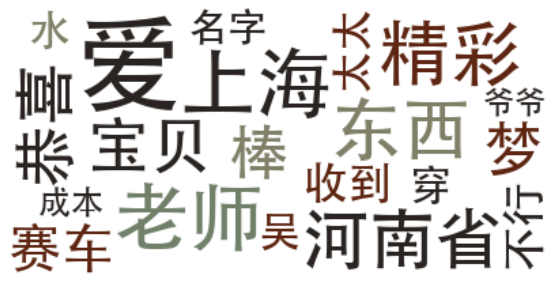

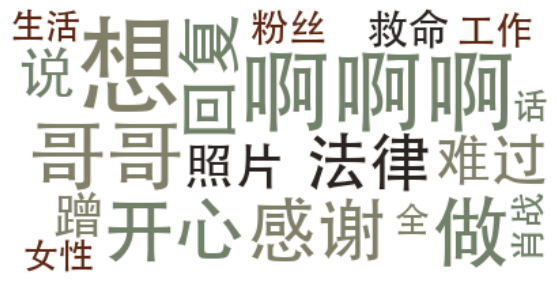

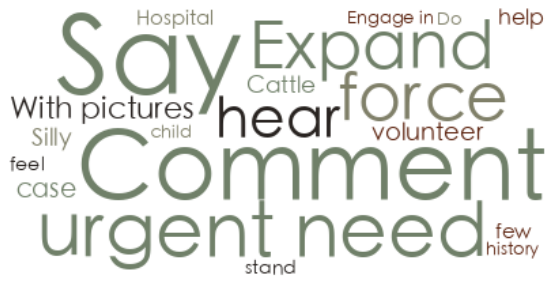

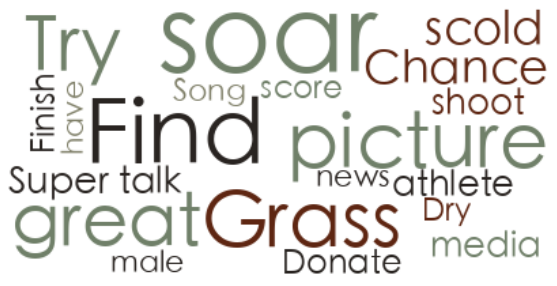

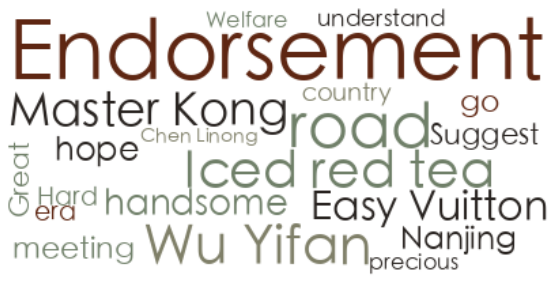

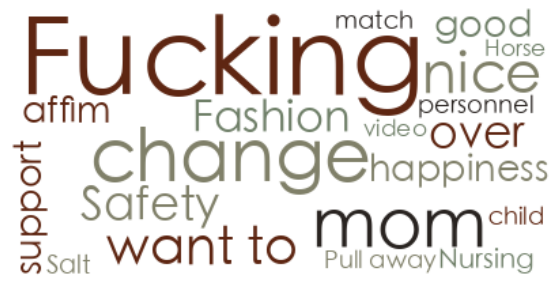

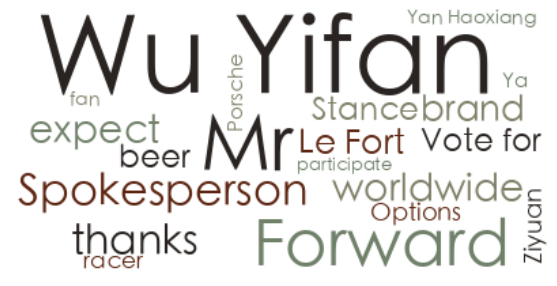

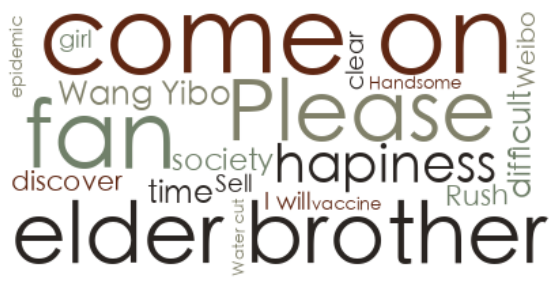

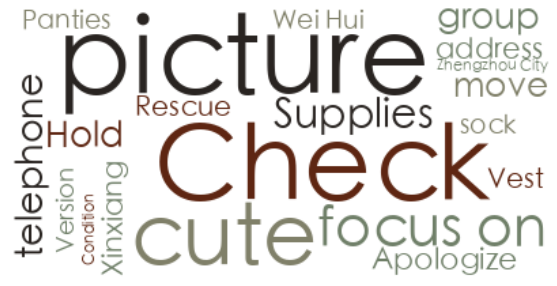

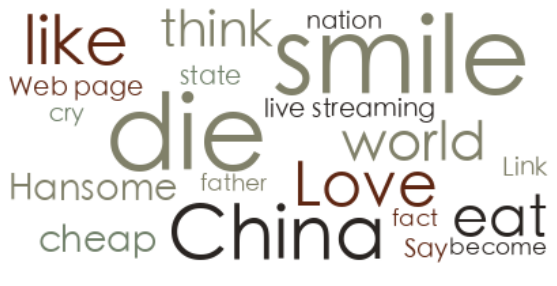

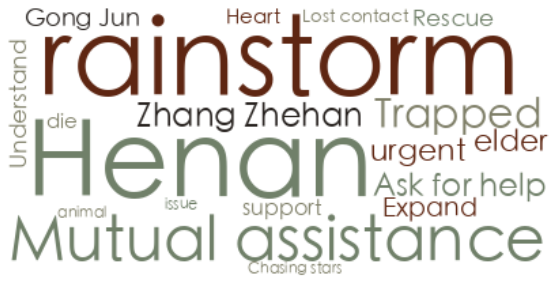

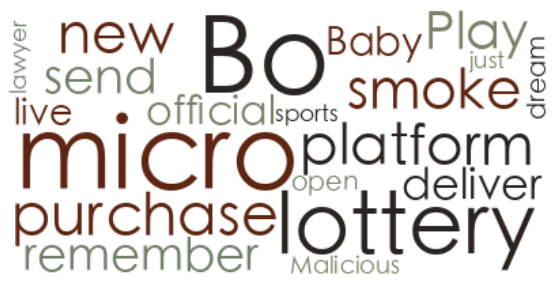

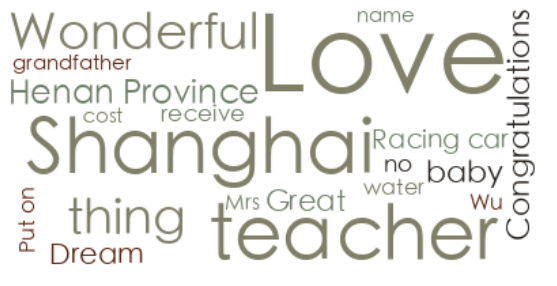

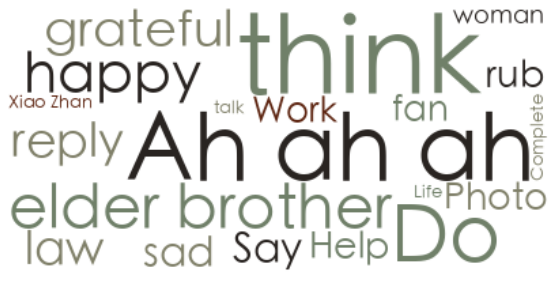

In [203]:
find_location_topic('上海',False)

In [275]:
dt_object = datetime.fromtimestamp(temp_df['timestamp_month'].iloc[1]).strftime('%Y-%m')
dt_object

'2020-11'

In [233]:
a = datetime.strptime('2021-7','%Y-%m')
a.timestamp()

1625097600.0

In [248]:
temp_df['timestamp_month'][0].map(lambda x: datetime.fromtimestamp(x).strptime('2021-7','%Y-%m'))

ValueError: Invalid value NaN (not a number)

In [277]:
a =map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m'),list(temp_df['timestamp_month'].values))

repost_weibo_comment source_weibo_content     user_id general_device  \
0                     0                   18  6434735528            NaN   
1                     0                   37  6434735528            NaN   
2                     0                  774  6434735528            NaN   
3                     0                  584  6434735528            NaN   
4                     0                35267  6434735528            NaN   
..                  ...                  ...         ...            ...   
36                    0                   19  3800833351            NaN   
37                    0                  399  3800833351            NaN   
0                     1                  138  6325684814            NaN   
0                     2                  529  6644008312            NaN   
0                     0               589738  7403182444            NaN   

    censored_post  timestamp_month gender  #tweets  #follower  #following  \
0           False              NaN      f      254        126         597   
1           False              NaN      f      254        126         597   
2           False              NaN      f      254        126         597   
3           False              NaN      f      254        126         597   
4           False              NaN      f      254        126         597   
..            ...              ...    ...      ...        ...         ...   
36          False              NaN      f      345        405         219   
37          False              NaN      f      345        405         219   
0           False              NaN      m        7          2         303   
0           False              NaN      f       18          2         272   
0           False              NaN      f        4          1         177   

    verification  #censored_posts  #follower_percentile_grouped province  \
0          False                0                             7       北京   
1          False                0                             7       北京   
2          False                0                             7       北京   
3          False                0                             7       北京   
4          False                0                             7       北京   
..           ...              ...                           ...      ...   
36          True                0                             9       北京   
37          True                0                             9       北京   
0          False                0                             1       其他   
0          False                0                             1       其他   
0          False                0                             1       其他   

    #collected_posts  province_gdp  censored_user  censored_ratio  
0                 55         23805          False             0.0  
1                 55         23805          False             0.0  
2                 55         23805          False             0.0  
3                 55         23805          False             0.0  
4                 55         23805          False             0.0  
..               ...           ...            ...             ...  
36                38         23805          False             0.0  
37                38         23805          False             0.0  
0                  1             0          False             0.0  
0                  2             0          False             0.0  
0                  2             0          False             0.0  

[2306 rows x 18 columns]

In [299]:
temp_df[temp_df['repost_weibo_comment']==0]

repost_weibo_comment source_weibo_content     user_id general_device  \
0                     0                   18  6434735528            NaN   
1                     0                   37  6434735528            NaN   
2                     0                  774  6434735528            NaN   
3                     0                  584  6434735528            NaN   
4                     0                35267  6434735528            NaN   
..                  ...                  ...         ...            ...   
33                    0               150486  3800833351            NaN   
34                    0                 3677  3800833351            NaN   
35                    0                  331  3800833351            NaN   
36                    0                   19  3800833351            NaN   
37                    0                  399  3800833351            NaN   

    censored_post  timestamp_month gender  #tweets  #follower  #following  \
0           False              NaN      f      254        126         597   
1           False              NaN      f      254        126         597   
2           False              NaN      f      254        126         597   
3           False              NaN      f      254        126         597   
4           False              NaN      f      254        126         597   
..            ...              ...    ...      ...        ...         ...   
33          False              NaN      f      345        405         219   
34          False              NaN      f      345        405         219   
35          False              NaN      f      345        405         219   
36          False              NaN      f      345        405         219   
37          False              NaN      f      345        405         219   

    verification  #censored_posts  #follower_percentile_grouped province  \
0          False                0                             7       北京   
1          False                0                             7       北京   
2          False                0                             7       北京   
3          False                0                             7       北京   
4          False                0                             7       北京   
..           ...              ...                           ...      ...   
33          True                0                             9       北京   
34          True                0                             9       北京   
35          True                0                             9       北京   
36          True                0                             9       北京   
37          True                0                             9       北京   

    #collected_posts  province_gdp  censored_user  censored_ratio  
0                 55         23805          False             0.0  
1                 55         23805          False             0.0  
2                 55         23805          False             0.0  
3                 55         23805          False             0.0  
4                 55         23805          False             0.0  
..               ...           ...            ...             ...  
33                38         23805          False             0.0  
34                38         23805          False             0.0  
35                38         23805          False             0.0  
36                38         23805          False             0.0  
37                38         23805          False             0.0  

[1419 rows x 18 columns]

<a name="validation"/>

# Validation

In [10]:
validation_df = pd.read_csv('/home/sean/Desktop/CSC440_project/data_general/verification_locations_combined.csv', names=['id','location'])

In [12]:
validation_df['location'] = validation_df['location'].map(lambda x: x.split(' ')[0])

In [38]:
validation_user

location  count     ratio
0        上海   1302  0.023298
1        云南    620  0.011094
2        其他  25231  0.451481
3       内蒙古    300  0.005368
4        北京   2634  0.047133
5        台湾    173  0.003096
6        吉林    369  0.006603
7        四川   1369  0.024497
8        天津    391  0.006997
9        宁夏     95  0.001700
10       安徽    838  0.014995
11       山东   1684  0.030133
12       山西    598  0.010701
13       广东   3255  0.058245
14       广西    612  0.010951
15       新疆    302  0.005404
16       江苏   1906  0.034106
17       江西    611  0.010933
18       河北   1138  0.020363
19       河南   1614  0.028881
20       浙江   1943  0.034768
21       海南    206  0.003686
22       海外   1913  0.034231
23       湖北   1009  0.018055
24       湖南    934  0.016713
25       澳门     59  0.001056
26       甘肃    267  0.004778
27       福建   1067  0.019093
28       西藏     72  0.001288
29       贵州    396  0.007086
30       辽宁    801  0.014333
31       重庆    775  0.013868
32       陕西    696  0.012454
33       青海     86  0.001539
34       香港    160  0.002863
35      黑龙江    459  0.008213

Text(0.5, 1.0, 'Validation Data Set Distribution')

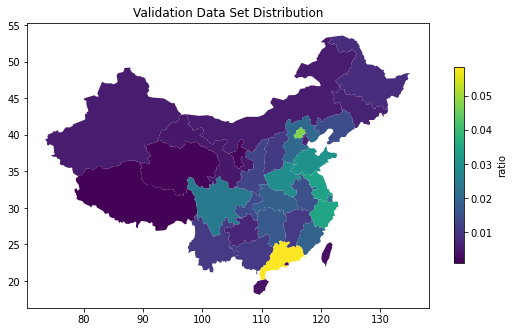

In [45]:
validation_user = pd.DataFrame(validation_df.groupby('location').size()).reset_index(drop=False).rename(columns={0:'count'})
validation_user['ratio'] = validation_user['count'].map(lambda x: x / np.sum(validation_user['count']))
validation_user.sort_values(by = 'ratio')

kwargs = {}
validation_map = china_geo_df.merge(validation_user, left_on='name', right_on=validation_user.columns[0])
kwargs.setdefault('figsize', (9,6))
kwargs.setdefault('legend', True)
kwargs.setdefault('legend_kwds',{'label': 'ratio','shrink': 0.6})
ax = validation_map.plot(column='ratio', **kwargs)
ax.set_title('Validation Data Set Distribution')

Text(0.5, 1.0, 'Collected User Distribution')

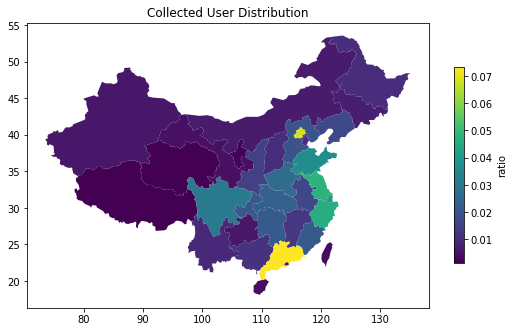

In [44]:
user_with_ratio = pd.DataFrame(users_with_content.groupby(['province']).size()).reset_index(drop=False).rename(columns={0:'count'})
user_with_ratio['ratio'] = user_with_ratio['count'].map(lambda x: x / np.sum(user_with_ratio['count']))
user_with_ratio.sort_values(by = 'ratio')

kwargs = {}
distribution_map = china_geo_df.merge(user_with_ratio, left_on='name', right_on=user_with_ratio.columns[0])
kwargs.setdefault('figsize', (9,6))
kwargs.setdefault('legend', True)
kwargs.setdefault('legend_kwds',{'label': 'ratio','shrink': 0.6})
ax = distribution_map.plot(column='ratio', **kwargs)
ax.set_title('Collected User Distribution')

<AxesSubplot:xlabel='censored_ratio', ylabel='Density'>

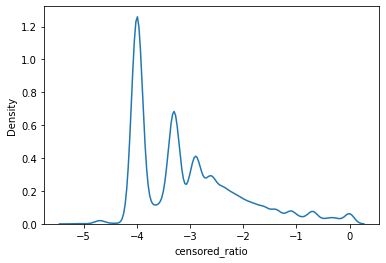

In [53]:
import seaborn as sns
k = users_with_content[users_with_content['censored']==True]['censored_ratio']
k = np.log(k)
sns.kdeplot(data = k)

In [27]:
np.sum(user_with_ratio['count'])

574357